# Functions

In [1]:
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import d2l
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat
from torch.optim.lr_scheduler import ReduceLROnPlateau
import decimal
from matplotlib import ticker

In [2]:
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Set the device to the first available GPU
    device = torch.device("cuda:0")
else:
    # If GPU is not available, use the CPU
    device = torch.device("cpu")

In [4]:
class GRUCellNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRUCell(input_dim, hidden_dim, bias=True)                
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_dim, hidden_dim) if i == 0 else nn.GRUCell(hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm outside GRU cells

        
        
    def forward(self, x, h=None):
        if h is None:
            h = [torch.zeros(x.size(0), self.hidden_dim) for _ in range(self.num_layers)]
        
        hidden_states = []
        
        for t in range(x.size(1)):
            input_t = x[:, t, :]
            new_hidden_states = []
            for layer_idx, gru_cell in enumerate(self.gru_cells):
                h[layer_idx] = gru_cell(input_t, h[layer_idx])
                new_hidden_states.append(h[layer_idx])
                input_t = h[layer_idx]  # Update input_t with the new hidden state for the next layer
            hidden_states.append(new_hidden_states)
        
        last_hidden_states = [layer_states[-1] for layer_states in hidden_states]
        # Apply BatchNorm to the last hidden state
        last_hidden_states[-1] = self.batch_norm(last_hidden_states[-1])
        out = self.fc(last_hidden_states[-1])
        out = torch.sigmoid(out)
        
        return out, last_hidden_states , hidden_states 

In [5]:
# Custom Dataset class for loading data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Implement data retrieval for each index
        input_data = self.X[idx]
        target_data = self.y[idx]
        input_data = input_data.unsqueeze(0)
        
        # Convert data to torch tensors if required
        input_tensor = torch.Tensor(input_data)
        target_tensor = torch.Tensor(target_data)
        
        return input_tensor, target_tensor

In [6]:
def accuracy(correct, total):
    return float(correct)/total

In [7]:
def train(dataloader, model, optimizer, loss_fn, scheduler=None, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device)
    model.train()
    predicted_probs = []
    predicted_labels = []
    hidden_states = []
    for x, y in dataloader:
        x = x.to(device).float()
        y = y.to(device).float()
        
        optimizer.zero_grad()
        hidden_states_batch = []  # Initialize a list to store hidden states for the current batch        
        out, last_hidden_states, hidden_states = model(x)
        #y_prob = torch.sigmoid(out)
        # Append the predicted probabilities to the list
        predicted_probs.append(out.cpu().detach().numpy())
        loss = loss_fn(out, y)
        epoch_loss.append(loss.item())

        #hidden_states.append(hidden)
        
        y_pred = torch.round(out)
        # Append the batch's hidden states to the list
        for layer_state in last_hidden_states:
            hidden_states_batch.append(layer_state.cpu().detach().numpy())
        epoch_correct += sum((y == y_pred).flatten()).item()
        epoch_total += y.numel()
        # Append the batch's hidden states to the overall hidden_states list
        hidden_states.append(hidden_states_batch)
        
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        predicted_labels.extend(zip(y_pred.cpu().detach().cpu().numpy(), y.cpu().numpy()))
        if scheduler:
            scheduler.step(loss)
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs, hidden_states 

In [8]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device).float()
    model.eval()
    predicted_probs = []
    predicted_labels = []
    hidden_states = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device).float()
            y = y.to(device).float()
            
            out, last_hidden_states = model(x)
            
            loss = loss_fn(out, y)
            epoch_loss.append(loss.item())

            hidden_states.append(hidden)
            #y_pred = torch.sigmoid(out)
            predicted_probs.append(out.cpu().detach().numpy())
            y_pred = torch.round(out)
            epoch_correct += sum((y == y_pred).flatten())
            epoch_total += y.numel()
            predicted_labels.extend(zip(y_pred.cpu().numpy(), y.cpu().numpy()))
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs, hidden_states

In [9]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, schedule_on_train=True, verbose=True):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    train_hidden_states, val_hidden_states = [], []
    
    for epoch in range(num_epochs):
        epoch_train_loss, epoch_train_acc, train_preds, train_probs, train_hidden = train(train_dataloader, model, optimizer, loss_fn, scheduler, device)
        
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        train_hidden_states.extend(train_hidden)
        
        if val_dataloader is not None:
            epoch_val_loss, epoch_val_acc, val_preds, val_probs, val_hidden = validate(val_dataloader, model, loss_fn, device)
        
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)

            val_hidden_states.extend(val_hidden)
        
        #if isinstance(scheduler, ReduceLROnPlateau):
        #    scheduler.step(epoch_train_acc if schedule_on_train or val_dataloader is None else epoch_val_acc)
            
        if epoch % 10 == 0:
            val_str = f", val loss: {epoch_val_loss}, val acc: {epoch_val_acc}" if val_dataloader is not None else ""
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, train acc: {epoch_train_acc}{val_str}")
        if epoch == num_epochs - 1:  # Store values only for the final epoch
            train_predicted_labels = train_preds
            #val_predicted_labels = val_preds
            train_probs_final = train_probs
            #val_probs_final = val_probs
            if val_dataloader is not None:
                val_predicted_labels = val_preds
                val_probs_final = val_probs

    if val_dataloader is not None:        
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, val_predicted_labels, train_probs_final, val_probs_final, train_hidden_states, val_hidden_states
    else: 
        return train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states

In [10]:
def specificity(y_true, y_pred):
    true_negatives = ((y_true == 0) & (y_pred == 0)).sum()
    false_positives = ((y_true == 0) & (y_pred == 1)).sum()

    specificity = true_negatives / (true_negatives + false_positives)
    
    return specificity

# Training & Gradients

# M Model

Epoch 0, train loss: 0.872759222984314, train acc: 0.36991189427312776
Epoch 10, train loss: 0.6640677452087402, train acc: 0.5976651982378854
Epoch 20, train loss: 0.5496270060539246, train acc: 0.7225550660792952
Epoch 30, train loss: 0.49288004636764526, train acc: 0.7763436123348018
Epoch 40, train loss: 0.45428404211997986, train acc: 0.8181497797356828
Epoch 50, train loss: 0.42156264185905457, train acc: 0.8374449339207048
Epoch 60, train loss: 0.39218923449516296, train acc: 0.8490748898678414
Epoch 70, train loss: 0.3661884367465973, train acc: 0.8655066079295154
Epoch 80, train loss: 0.34248635172843933, train acc: 0.8845814977973568
Epoch 90, train loss: 0.3210641145706177, train acc: 0.8990308370044053
Epoch 100, train loss: 0.30184870958328247, train acc: 0.9110132158590308
Epoch 110, train loss: 0.2845894992351532, train acc: 0.9159030837004405
Epoch 120, train loss: 0.26909899711608887, train acc: 0.9184140969162996
Epoch 130, train loss: 0.2553165555000305, train acc: 0

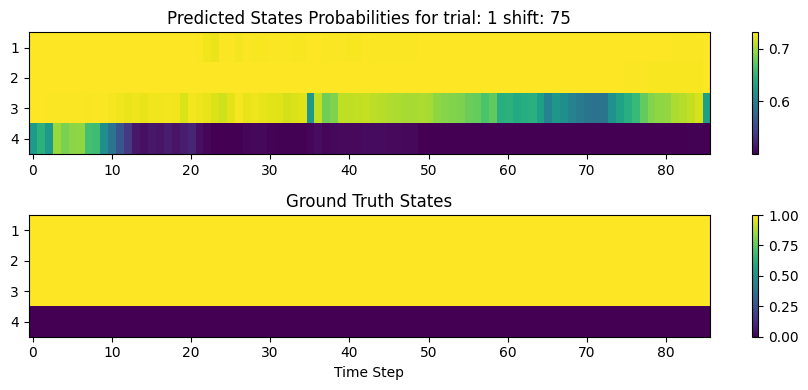

Epoch 0, train loss: 0.7322081327438354, train acc: 0.49570131375579596
Epoch 10, train loss: 0.5803104043006897, train acc: 0.7536707882534776
Epoch 20, train loss: 0.5006961822509766, train acc: 0.8066074188562596
Epoch 30, train loss: 0.45640116930007935, train acc: 0.8295015455950541
Epoch 40, train loss: 0.42074114084243774, train acc: 0.8675618238021638
Epoch 50, train loss: 0.3897145092487335, train acc: 0.8710394126738794
Epoch 60, train loss: 0.3636867105960846, train acc: 0.8743238021638331
Epoch 70, train loss: 0.3408437669277191, train acc: 0.8811340803709428
Epoch 80, train loss: 0.32073062658309937, train acc: 0.8917600463678517
Epoch 90, train loss: 0.3028245270252228, train acc: 0.8970247295208655
Epoch 100, train loss: 0.28661057353019714, train acc: 0.9027724111282844
Epoch 110, train loss: 0.27178603410720825, train acc: 0.9076506955177743
Epoch 120, train loss: 0.258171409368515, train acc: 0.9145092735703245
Epoch 130, train loss: 0.2456093579530716, train acc: 0.9

<Figure size 640x480 with 0 Axes>

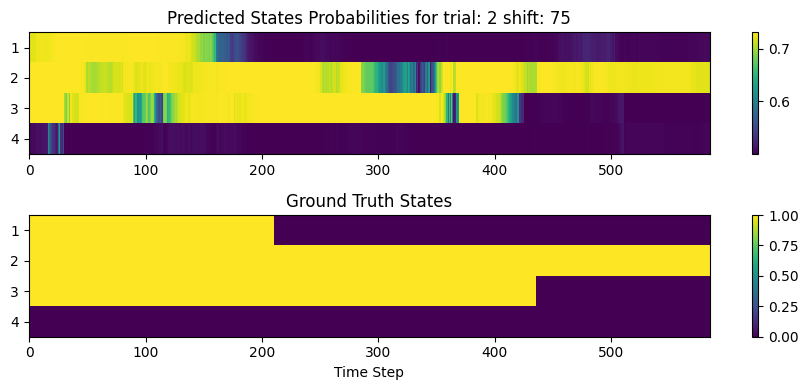

Epoch 0, train loss: 0.7798655033111572, train acc: 0.42885576745047216
Epoch 10, train loss: 0.6122338175773621, train acc: 0.678948342899463
Epoch 20, train loss: 0.534788966178894, train acc: 0.7524532493982595
Epoch 30, train loss: 0.482718825340271, train acc: 0.8056378448435475
Epoch 40, train loss: 0.44029733538627625, train acc: 0.825448990927606
Epoch 50, train loss: 0.40600043535232544, train acc: 0.8432697648583596
Epoch 60, train loss: 0.37745779752731323, train acc: 0.870162932790224
Epoch 70, train loss: 0.354262113571167, train acc: 0.8861784854656545
Epoch 80, train loss: 0.33435457944869995, train acc: 0.8963617848546566
Epoch 90, train loss: 0.31635424494743347, train acc: 0.9020088872431031
Epoch 100, train loss: 0.2996982932090759, train acc: 0.9080725791520089
Epoch 110, train loss: 0.2842749059200287, train acc: 0.9127476393260507
Epoch 120, train loss: 0.2700018882751465, train acc: 0.917468987224588
Epoch 130, train loss: 0.25682738423347473, train acc: 0.921357

<Figure size 640x480 with 0 Axes>

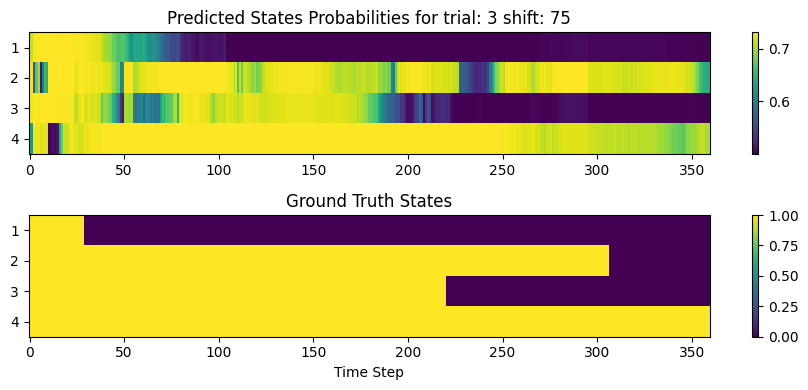

Epoch 0, train loss: 0.6981302499771118, train acc: 0.5518999073215941
Epoch 10, train loss: 0.5730640292167664, train acc: 0.7271547729379054
Epoch 20, train loss: 0.5047808289527893, train acc: 0.7749768303985172
Epoch 30, train loss: 0.45592063665390015, train acc: 0.8046802594995366
Epoch 40, train loss: 0.41984111070632935, train acc: 0.8377201112140871
Epoch 50, train loss: 0.38992172479629517, train acc: 0.8490268767377201
Epoch 60, train loss: 0.36448922753334045, train acc: 0.8629286376274328
Epoch 70, train loss: 0.34257403016090393, train acc: 0.8849860982391103
Epoch 80, train loss: 0.3229042589664459, train acc: 0.8970342910101946
Epoch 90, train loss: 0.30472832918167114, train acc: 0.9072752548656163
Epoch 100, train loss: 0.2877645492553711, train acc: 0.9151529193697868
Epoch 110, train loss: 0.27213266491889954, train acc: 0.9176088971269695
Epoch 120, train loss: 0.25766491889953613, train acc: 0.9198795180722892
Epoch 130, train loss: 0.24416673183441162, train acc:

<Figure size 640x480 with 0 Axes>

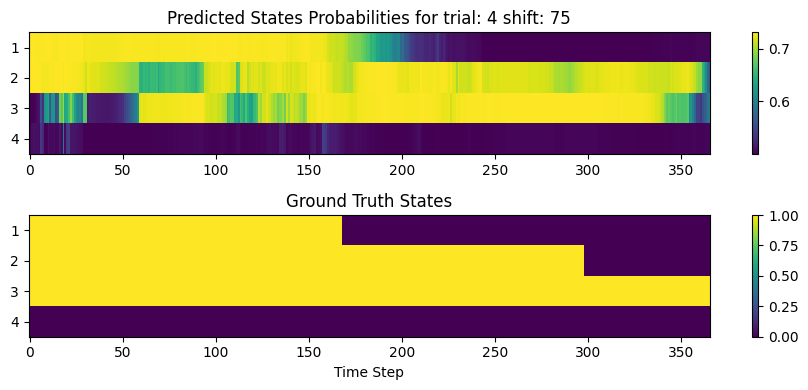

Epoch 0, train loss: 0.6920027136802673, train acc: 0.5442209147845891
Epoch 10, train loss: 0.5758734941482544, train acc: 0.7129910799013095
Epoch 20, train loss: 0.4987925589084625, train acc: 0.7988233061301955
Epoch 30, train loss: 0.4439668357372284, train acc: 0.8285253368760676
Epoch 40, train loss: 0.4015137553215027, train acc: 0.8583697096223192
Epoch 50, train loss: 0.36692750453948975, train acc: 0.8782975896754602
Epoch 60, train loss: 0.341084748506546, train acc: 0.8946669197191118
Epoch 70, train loss: 0.31988951563835144, train acc: 0.9009774150692731
Epoch 80, train loss: 0.3010447025299072, train acc: 0.9107041184285443
Epoch 90, train loss: 0.2838144600391388, train acc: 0.9169197191117859
Epoch 100, train loss: 0.26782357692718506, train acc: 0.9201935851205162
Epoch 110, train loss: 0.2529715895652771, train acc: 0.92232871512621
Epoch 120, train loss: 0.23966021835803986, train acc: 0.9230404251281078
Epoch 130, train loss: 0.22783377766609192, train acc: 0.9263

<Figure size 640x480 with 0 Axes>

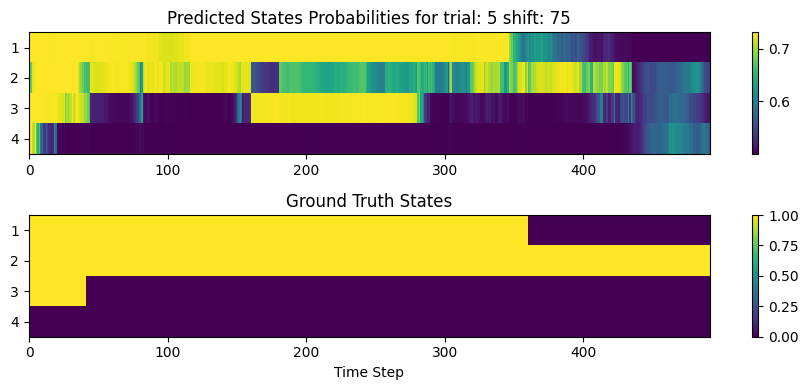

Epoch 0, train loss: 0.7586509585380554, train acc: 0.43752404771065795
Epoch 10, train loss: 0.6259772777557373, train acc: 0.694113120430935
Epoch 20, train loss: 0.5540292859077454, train acc: 0.7420161600615621
Epoch 30, train loss: 0.5057395696640015, train acc: 0.7547133512889573
Epoch 40, train loss: 0.4659276306629181, train acc: 0.7938149288187765
Epoch 50, train loss: 0.4331263601779938, train acc: 0.8360427087341286
Epoch 60, train loss: 0.4037665128707886, train acc: 0.8548961138899577
Epoch 70, train loss: 0.3770900368690491, train acc: 0.8690842631781455
Epoch 80, train loss: 0.3529568910598755, train acc: 0.8809638322431704
Epoch 90, train loss: 0.330777108669281, train acc: 0.8942862639476722
Epoch 100, train loss: 0.31035709381103516, train acc: 0.9059253559061178
Epoch 110, train loss: 0.29146966338157654, train acc: 0.9128991919969219
Epoch 120, train loss: 0.2738628089427948, train acc: 0.9175644478645633
Epoch 130, train loss: 0.2583393454551697, train acc: 0.92184

<Figure size 640x480 with 0 Axes>

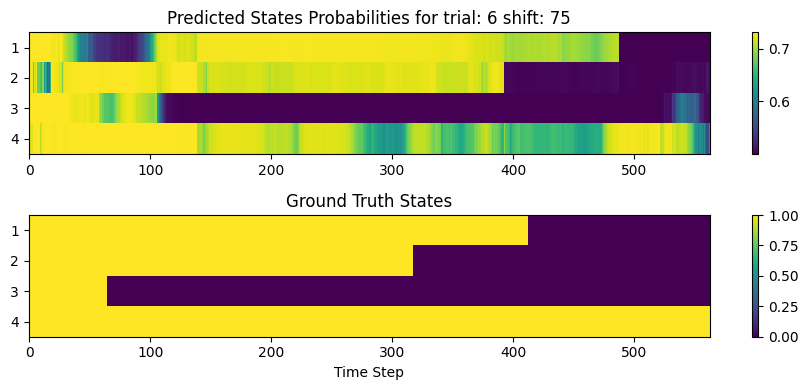

Epoch 0, train loss: 0.8868700265884399, train acc: 0.3550578034682081
Epoch 10, train loss: 0.7024557590484619, train acc: 0.4680635838150289
Epoch 20, train loss: 0.5853093862533569, train acc: 0.7129576107899808
Epoch 30, train loss: 0.5183347463607788, train acc: 0.7872832369942196
Epoch 40, train loss: 0.475788414478302, train acc: 0.8125240847784201
Epoch 50, train loss: 0.44253382086753845, train acc: 0.8286127167630057
Epoch 60, train loss: 0.4129912555217743, train acc: 0.8425337186897881
Epoch 70, train loss: 0.3861309885978699, train acc: 0.8572254335260115
Epoch 80, train loss: 0.36209729313850403, train acc: 0.8780828516377649
Epoch 90, train loss: 0.3404897451400757, train acc: 0.8952312138728323
Epoch 100, train loss: 0.3212078809738159, train acc: 0.903805394990366
Epoch 110, train loss: 0.30404165387153625, train acc: 0.9035645472061657
Epoch 120, train loss: 0.2882396876811981, train acc: 0.9059248554913295
Epoch 130, train loss: 0.27407893538475037, train acc: 0.9080

<Figure size 640x480 with 0 Axes>

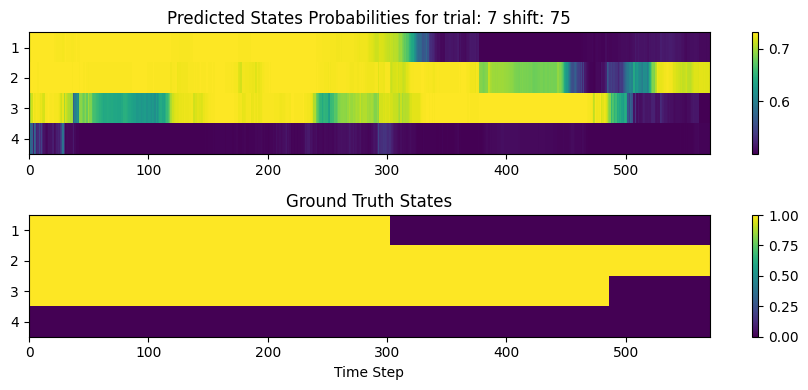

Epoch 0, train loss: 0.8301402926445007, train acc: 0.38284115920763023
Epoch 10, train loss: 0.646475076675415, train acc: 0.5776320616287601
Epoch 20, train loss: 0.5664626955986023, train acc: 0.682089141599413
Epoch 30, train loss: 0.5179597735404968, train acc: 0.7271643433602347
Epoch 40, train loss: 0.47775471210479736, train acc: 0.7791636096845195
Epoch 50, train loss: 0.44190284609794617, train acc: 0.8203870139398386
Epoch 60, train loss: 0.4099556803703308, train acc: 0.8547780630961115
Epoch 70, train loss: 0.3817926347255707, train acc: 0.8700476889214968
Epoch 80, train loss: 0.3559681475162506, train acc: 0.8855465884079237
Epoch 90, train loss: 0.3318709433078766, train acc: 0.9082446808510638
Epoch 100, train loss: 0.31026577949523926, train acc: 0.9173239178283199
Epoch 110, train loss: 0.2908400893211365, train acc: 0.9194790902421129
Epoch 120, train loss: 0.2743570804595947, train acc: 0.9246606749816582
Epoch 130, train loss: 0.2594379186630249, train acc: 0.9263

<Figure size 640x480 with 0 Axes>

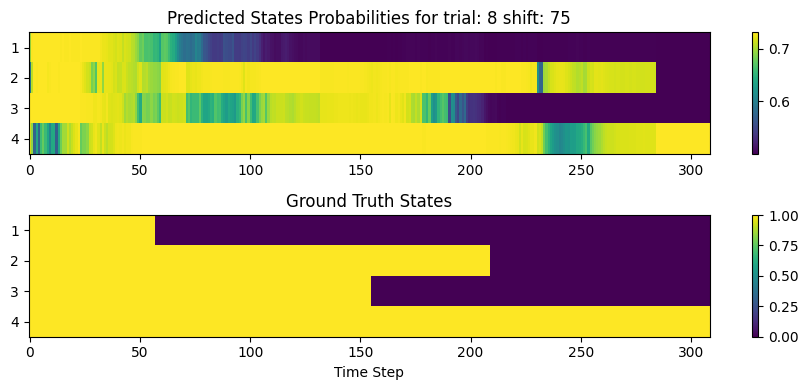

Epoch 0, train loss: 0.7352964282035828, train acc: 0.5041085419453468
Epoch 10, train loss: 0.5866066217422485, train acc: 0.6532103955665965
Epoch 20, train loss: 0.5033010244369507, train acc: 0.7716415058283967
Epoch 30, train loss: 0.4526425898075104, train acc: 0.8258169310147143
Epoch 40, train loss: 0.41459956765174866, train acc: 0.8549589145805465
Epoch 50, train loss: 0.3831445276737213, train acc: 0.8760749092298873
Epoch 60, train loss: 0.3566519320011139, train acc: 0.8862507166061533
Epoch 70, train loss: 0.33417779207229614, train acc: 0.8942289317790942
Epoch 80, train loss: 0.3147624135017395, train acc: 0.9043091916682591
Epoch 90, train loss: 0.29764601588249207, train acc: 0.9072233900248423
Epoch 100, train loss: 0.2821464538574219, train acc: 0.9092776609975157
Epoch 110, train loss: 0.2679981589317322, train acc: 0.9106630995604815
Epoch 120, train loss: 0.2551494240760803, train acc: 0.9129562392509077
Epoch 130, train loss: 0.2435760200023651, train acc: 0.914

<Figure size 640x480 with 0 Axes>

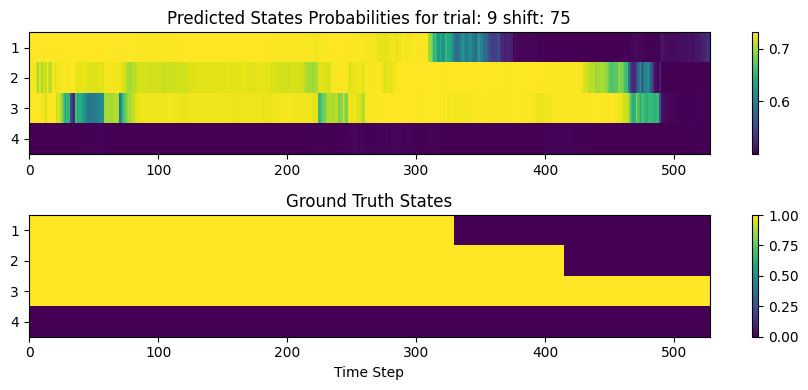

Epoch 0, train loss: 0.7446944117546082, train acc: 0.44049129804205944
Epoch 10, train loss: 0.6256099343299866, train acc: 0.6267222625090645
Epoch 20, train loss: 0.5535029172897339, train acc: 0.7324601160261058
Epoch 30, train loss: 0.5016939640045166, train acc: 0.8086928934010152
Epoch 40, train loss: 0.45561420917510986, train acc: 0.8548313995649021
Epoch 50, train loss: 0.415348082780838, train acc: 0.8763143582306019
Epoch 60, train loss: 0.3810841739177704, train acc: 0.8931744017403916
Epoch 70, train loss: 0.3512929081916809, train acc: 0.9030094271211022
Epoch 80, train loss: 0.325584352016449, train acc: 0.9082668600435098
Epoch 90, train loss: 0.3032313883304596, train acc: 0.9149292965917332
Epoch 100, train loss: 0.2834368646144867, train acc: 0.9172860768672951
Epoch 110, train loss: 0.26634272933006287, train acc: 0.9215010877447426
Epoch 120, train loss: 0.2511850595474243, train acc: 0.9243564176939811
Epoch 130, train loss: 0.23764710128307343, train acc: 0.9257

<Figure size 640x480 with 0 Axes>

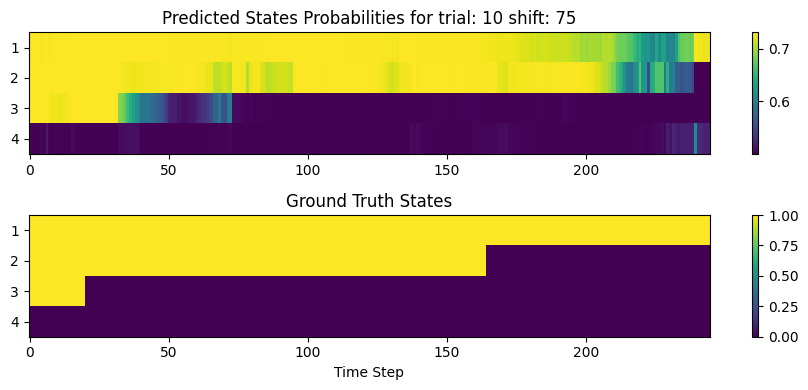

Epoch 0, train loss: 0.6793630719184875, train acc: 0.6071165869805075
Epoch 10, train loss: 0.5671907663345337, train acc: 0.6956601691798455
Epoch 20, train loss: 0.49838975071907043, train acc: 0.7842497241632953
Epoch 30, train loss: 0.4498814642429352, train acc: 0.8195568223611622
Epoch 40, train loss: 0.413344144821167, train acc: 0.8418076498712762
Epoch 50, train loss: 0.38461199402809143, train acc: 0.854404192717911
Epoch 60, train loss: 0.36036306619644165, train acc: 0.8696671570430305
Epoch 70, train loss: 0.33917587995529175, train acc: 0.878539904376609
Epoch 80, train loss: 0.31999850273132324, train acc: 0.8987679293858036
Epoch 90, train loss: 0.3020583689212799, train acc: 0.9058017653549099
Epoch 100, train loss: 0.28539028763771057, train acc: 0.9149043766090474
Epoch 110, train loss: 0.2696378231048584, train acc: 0.9190878999632218
Epoch 120, train loss: 0.254830002784729, train acc: 0.9226278043398308
Epoch 130, train loss: 0.2411169707775116, train acc: 0.9269

<Figure size 640x480 with 0 Axes>

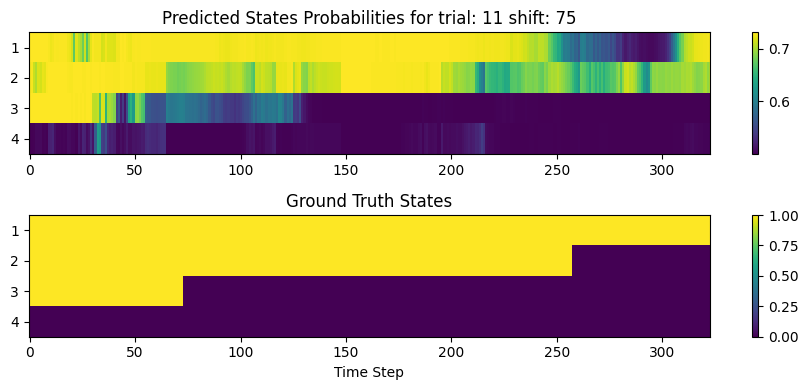

Epoch 0, train loss: 0.7289953827857971, train acc: 0.5550947867298578
Epoch 10, train loss: 0.5922466516494751, train acc: 0.6898468829748451
Epoch 20, train loss: 0.517653226852417, train acc: 0.7760663507109005
Epoch 30, train loss: 0.4664738178253174, train acc: 0.8319358366751731
Epoch 40, train loss: 0.4264070391654968, train acc: 0.8535362741523879
Epoch 50, train loss: 0.39342838525772095, train acc: 0.8619668246445498
Epoch 60, train loss: 0.36549311876296997, train acc: 0.875729128691214
Epoch 70, train loss: 0.3408801257610321, train acc: 0.8854356543930003
Epoch 80, train loss: 0.3192330598831177, train acc: 0.8943674808603719
Epoch 90, train loss: 0.3000120222568512, train acc: 0.9064892453518046
Epoch 100, train loss: 0.2827536463737488, train acc: 0.9199325555960627
Epoch 110, train loss: 0.26700785756111145, train acc: 0.9243528982865475
Epoch 120, train loss: 0.2525967061519623, train acc: 0.9264947138169887
Epoch 130, train loss: 0.23935741186141968, train acc: 0.9275

<Figure size 640x480 with 0 Axes>

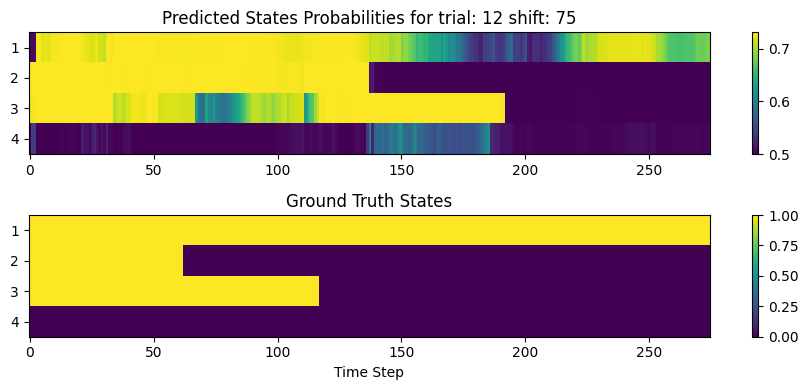

Epoch 0, train loss: 0.6777166724205017, train acc: 0.5575676176361616
Epoch 10, train loss: 0.5594265460968018, train acc: 0.7405983697665802
Epoch 20, train loss: 0.4877385199069977, train acc: 0.8291959985179697
Epoch 30, train loss: 0.4384057819843292, train acc: 0.8605502037791775
Epoch 40, train loss: 0.3985587954521179, train acc: 0.8731937754723972
Epoch 50, train loss: 0.3664657175540924, train acc: 0.8813449425713227
Epoch 60, train loss: 0.3401572108268738, train acc: 0.8955631715450166
Epoch 70, train loss: 0.31793296337127686, train acc: 0.8990829937013709
Epoch 80, train loss: 0.2991112470626831, train acc: 0.9077436087439793
Epoch 90, train loss: 0.28196460008621216, train acc: 0.9167747313819933
Epoch 100, train loss: 0.2661781907081604, train acc: 0.9215913301222675
Epoch 110, train loss: 0.25172722339630127, train acc: 0.9237680622452761
Epoch 120, train loss: 0.23867455124855042, train acc: 0.9248332715820674
Epoch 130, train loss: 0.22674188017845154, train acc: 0.9

<Figure size 640x480 with 0 Axes>

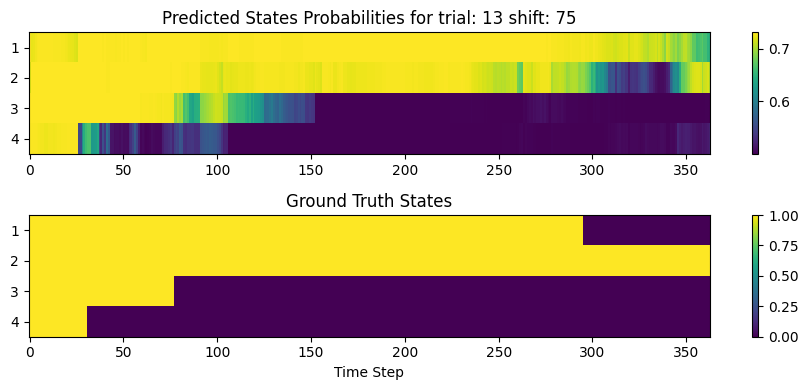

Epoch 0, train loss: 0.6719574928283691, train acc: 0.5616785580172737
Epoch 10, train loss: 0.559230625629425, train acc: 0.7509387908374014
Epoch 20, train loss: 0.48892369866371155, train acc: 0.8132275628989861
Epoch 30, train loss: 0.43737342953681946, train acc: 0.8507791963950432
Epoch 40, train loss: 0.39761999249458313, train acc: 0.874342846413819
Epoch 50, train loss: 0.3649607300758362, train acc: 0.8853266992114157
Epoch 60, train loss: 0.3365701735019684, train acc: 0.8949962448366504
Epoch 70, train loss: 0.3136608600616455, train acc: 0.8954187007134811
Epoch 80, train loss: 0.2940482497215271, train acc: 0.9044310927525347
Epoch 90, train loss: 0.2765888571739197, train acc: 0.9141945174615096
Epoch 100, train loss: 0.2607239782810211, train acc: 0.9212823882838903
Epoch 110, train loss: 0.2464895099401474, train acc: 0.9286988358993616
Epoch 120, train loss: 0.2336280196905136, train acc: 0.9325948178745775
Epoch 130, train loss: 0.22193723917007446, train acc: 0.9368

<Figure size 640x480 with 0 Axes>

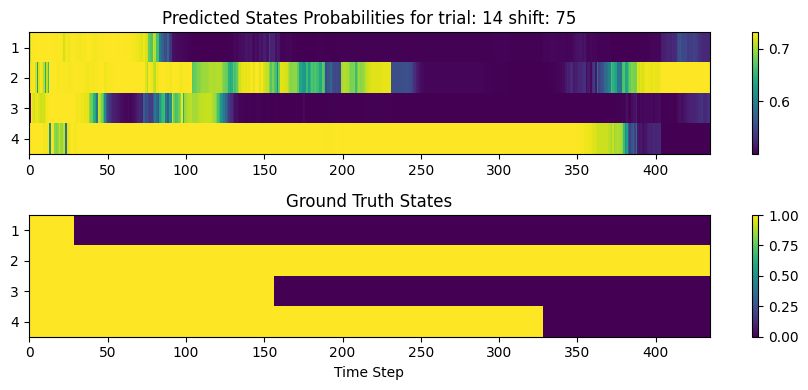

Epoch 0, train loss: 0.7025935649871826, train acc: 0.5623977458643883
Epoch 10, train loss: 0.5820422768592834, train acc: 0.6728322123250318
Epoch 20, train loss: 0.511185348033905, train acc: 0.7536811488820214
Epoch 30, train loss: 0.4584897458553314, train acc: 0.8021723323032176
Epoch 40, train loss: 0.4180534780025482, train acc: 0.826122523177604
Epoch 50, train loss: 0.38524821400642395, train acc: 0.8564351936011634
Epoch 60, train loss: 0.35706856846809387, train acc: 0.8799309216506089
Epoch 70, train loss: 0.33321666717529297, train acc: 0.8951099800036357
Epoch 80, train loss: 0.3122493028640747, train acc: 0.9030176331576077
Epoch 90, train loss: 0.29376038908958435, train acc: 0.9087893110343573
Epoch 100, train loss: 0.27704787254333496, train acc: 0.9138792946736957
Epoch 110, train loss: 0.2617884576320648, train acc: 0.9173786584257407
Epoch 120, train loss: 0.2478317767381668, train acc: 0.9227867660425377
Epoch 130, train loss: 0.23509135842323303, train acc: 0.92

<Figure size 640x480 with 0 Axes>

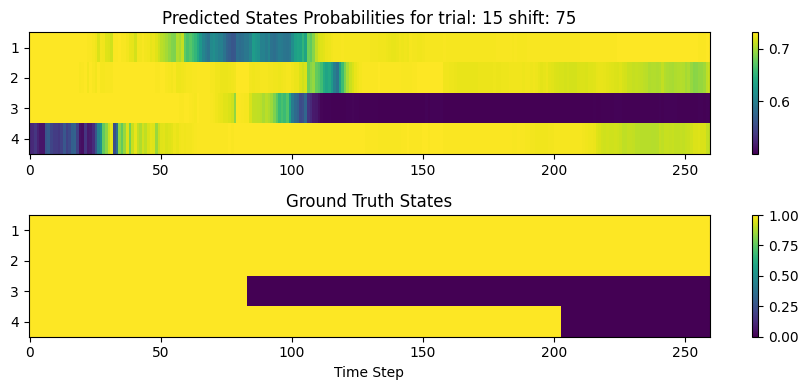

<Figure size 640x480 with 0 Axes>

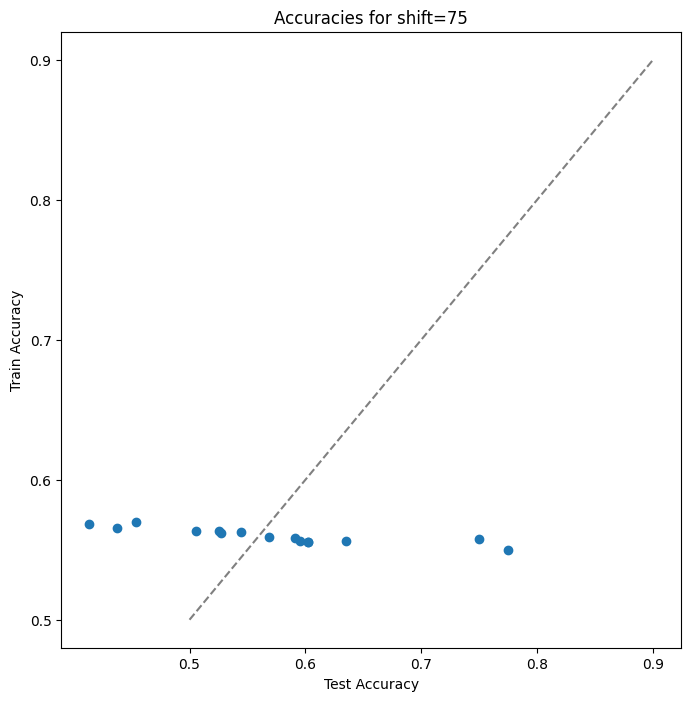

<Figure size 640x480 with 0 Axes>

In [36]:
# Hyperparameters
input_dim = 46
output_dim = 4
num_layers = 1
cmap = "viridis"

columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = "data_model_v3.csv"
df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns



probs_dict_mh = {}
hidden_states_dict = {}
test_predictions_dict_mh = {}
test_probs_dict_mh = {}
train_probs_dict_mh = {}
train_predictions_dict_mh = {}
train_accs_all = []
test_accs_all = []

for j in np.arange(1,16):    
    shift = 75
    set_values = j
    k = set_values - 1
    num_layers = 1
    hidden_dim = 30
    n_epochs = 600
    lr = 0.001
    model_name = 's_m_'+str(set_values)+"_"+str(n_epochs)+"_"+str(hidden_dim)+"_"+str(num_layers)+"_"+str(lr)+"_"
    # Create an instance of GRUCellNet
    model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

    # Define loss function and optimizer
    class_weights = torch.tensor([1.8]).to(device)
    loss_fn = nn.BCELoss()  
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)
    

    selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
    'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
    'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
    'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
    'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
    'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
    'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
    'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
    'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
    'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
    'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
    'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
    'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
    'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X, y = full_set.drop(columns=labels), full_set[labels]
    
    # reset index 
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

    # Create custom datasets for training, validation, and testing
    full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
    train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
    test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

    fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
    train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


    train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
        train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
    
                # Specify the folder path and the model filename
    folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_hypertuning/' 
    model_filename = model_name + '.pth'  
    state_dict = model.state_dict()

    # Combine the folder path and model filename
    full_model = os.path.join(folder_path, model_filename)

    # Save the model to the specified folder
    torch.save(state_dict, full_model)
    
    model.eval()  # Set the model to evaluation mode
    # Initialize an empty list to store predictions
    test_preds = []
    test_probs = []
    train_probs = []
    train_preds = []
    
    # Iterate through the test data batches
    for inputs, _ in test_dataloader:
        inputs = inputs.float()
        # Forward pass to get predictions
        with torch.no_grad():
            predictions, f,f = model(inputs)
            probabilities = torch.sigmoid(predictions)
            preds = torch.round(probabilities)

        # Append predictions to the list
        test_preds.append(preds)
        test_probs.append(probabilities)

    # Concatenate the predicted batches
    test_preds = torch.cat(test_preds, dim=0)
    test_probs = torch.cat(test_probs, dim=0)

    test_preds_array = test_preds.numpy()
    test_probs_array = test_probs.numpy()
    
    # Iterate through the test data batches
    for inputs, _ in train_dataloader:
        inputs = inputs.float()
        # Forward pass to get predictions
        with torch.no_grad():
            predictions, f,f = model(inputs)
            probabilities = torch.sigmoid(predictions)
            preds = torch.round(probabilities)

        # Append predictions to the list
        train_preds.append(preds)
        train_probs.append(probabilities)

    # Concatenate the predicted batches
    train_preds = torch.cat(train_preds, dim=0)
    train_probs = torch.cat(train_probs, dim=0)

    train_preds_array = train_preds.numpy()
    train_probs_array = train_probs.numpy()

    columns = ['s_1','s_2','s_3','s_4']
    test_probs_df = pd.DataFrame(test_probs_array)
    train_probs_df = pd.DataFrame(train_probs_array)
    train_probs_df.columns = columns
    test_probs_df.columns = columns 
    # Convert the tensor of predictions to a DataFrame
    test_preds_df = pd.DataFrame(test_preds_array, columns=y_test.columns, index=y_test.index)
    train_preds_df = pd.DataFrame(train_preds_array, columns=y_train.columns, index=y_train.index)
    # Calculate accuracy for each output state
    test_accuracies = (test_preds_df == y_test).mean()
    train_accuracies = (train_preds_df == y_train).mean()
    # Construct the key for the combination
    key = f"sm_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
    test_predictions_dict_mh[key] = test_preds_array 
    test_probs_dict_mh[key] = test_probs_array 
    
    train_predictions_dict_mh[key] = train_preds_array
    train_probs_dict_mh[key] = train_probs_array
    
    print(model_name)
    print("Accuracy for each output state in",model_name)
    print(np.mean(test_accuracies))
    test_accs = np.mean(test_accuracies)
    train_accs = np.mean(train_accuracies)
    
    test_accs_all.append(test_accs)
    train_accs_all.append(train_accs)
    
    #spec = specificity(y_test.values, test_preds_df.values)
    #print(spec)
    file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/predictions/solo_model/" + str(model_name) + "_test_probs.csv"
    np.savetxt(file_path, test_probs_array, delimiter=',')
    file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/predictions/solo_model/" + str(model_name) + "_train_probs.csv"
    np.savetxt(file_path,train_probs_array,delimiter=',')
    
    
        # Specify the name of the folder you want to create
    
    folder_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/"
    
    
    file_name = 'results_sm.txt'
    file_path = folder_path + file_name  # Replace with your desired file path
    value_to_save = model_name+"_"+str(test_accs)  # Replace with the value you want to save

    try:
        with open(file_path, "a") as file:
            # 2. Write the value to the file
            file.write(value_to_save)
            print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
        
    keys_list = list(test_probs_dict_mh.keys())
    trial_key = keys_list[k]
    y_hat = test_probs_dict_mh[trial_key]
    y_labels = ['1', '2', '3', '4']

    # Create a figure with a grid of subplots (2 rows, 1 column)
    fig, axs = plt.subplots(2,1, figsize=(9,4))

    # Create the first heatmap plot in the first subplot
    heatmap1 = axs[0].imshow(test_probs_array.T, cmap=cmap, aspect='auto', interpolation='none')

    # Add colorbar to the first heatmap subplot
    cbar1 = plt.colorbar(heatmap1, ax=axs[0])
    # Set the axis labels and title for the first heatmap subplot
    #axs[0].set_xlabel('Time Step')
    #axs[0].set_ylabel('Predicted State')
    axs[0].set_title('Predicted States Probabilities for trial: '+ str(set_values) + " " + "shift: " + str(shift))

    # Set the y-axis ticks and labels for the first heatmap subplot
    axs[0].set_yticks(np.arange(len(y_labels)))
    axs[0].set_yticklabels(y_labels)





    # Set the axis labels and title for the second heatmap subplot
    axs[1].set_xlabel('Time Step')
    #axs[1].set_ylabel('Predicted State')
    axs[1].set_title('Ground Truth States')
        # Create the second heatmap plot in the second subplot
    heatmap2 = axs[1].imshow(y_test.T, cmap=cmap, aspect='auto', interpolation='none')
    # Add colorbar to the second heatmap subplot
    cbar2 = plt.colorbar(heatmap2, ax=axs[1])
    # Set the y-axis ticks and labels for the second heatmap subplot
    axs[1].set_yticks(np.arange(len(y_labels)))
    axs[1].set_yticklabels(y_labels)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plot_name = str(model_name)+'_heatmap_v3.png'
    plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/new_heatmaps/'+plot_name)

    plt.show()
    plt.clf()
    
    
plt.figure(figsize=(8, 8))
scatter_plot = plt.scatter(test_accs_all, train_accs_all)
plt.xlabel('Test Accuracy')
plt.ylabel('Train Accuracy')
#plt.axis('equal')
plt.title("Accuracies for shift=75")
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.plot([0.5, 0.9], [0.5, 0.9], linestyle='--', color='gray')
plt.show()
plot_name = str(model_name)+'_accuracy.png'
plt.show()
plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/new_heatmaps/'+plot_name)

#plt.clf()   
    
            
            
        

In [ ]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = "data_model_v3.csv"
df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial','s_1','s_2','s_3','s_4']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns

In [ ]:
input_dim = 42
hidden_dim = 32
output_dim = 4
num_layers = 1
n_epochs =51
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)

In [ ]:
columns_to_shift

In [ ]:
#hidden_states_all = []
hidden_states_dict = {}
predictions_dict_m = {}

for j in np.arange(1,16):
    #for i in np.arange(0,151,10):
    for i in np.arange(10,11,10):
        shift = i
        set_values = j
        model_name = 'm'+str(shift)+'_'+'val'+str(set_values)+'_gates'


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])
        
        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        #print(X_train.columns)
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 
        
        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
        #print(X_train.shape[0])
        

        train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
        
        
        
        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_gradient/' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        #torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []
        

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, l, p = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()
        # Construct the key for the combination
        key = f"sm_shift{shift}_set{set_values}"

        # Store the predictions as NumPy arrays in the dictionary
        predictions_dict_m[key] = all_preds_array 

        print(str(model_name)+":"+str(np.mean(accuracies)))
        #print(np.mean(accuracies))

In [ ]:
for i in np.arange(1,16):
    shift = 10
    set_values = i
    #k = 0+15*(set_values-1)
    k = set_values - 1
    model_name = 'm_'+str(shift)+'_'+'val'+str(set_values)+'_gt'


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)

    #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
    'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
    'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
    'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
    'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
    'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
    'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
    'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
    'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
    'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
    'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
    'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
    'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
    'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    #,s_1_minus_'+str(shift),'s_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X, y = full_set.drop(columns=labels), full_set[labels]
    #print(X_train.columns)
    # reset index 
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

    y_tilda = y_tilda_org[y_tilda_org['trial']==set_values].drop(columns=['trial','id'])
    col_shift = ['s_1', 's_2', 's_3', 's_4']
    # Loop through unique trial values
        # Create shifted columns for each column in columns_to_shift
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_tilda[new_col_name] = y_tilda[col].shift(shift)
        
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_test[new_col_name] = y_test[col].shift(shift)
        
    y_test = y_test.dropna()
    #print(y_tilda.columns)
    y_test = y_test.drop(columns=['s_1', 's_2', 's_3', 's_4'])

    # Drop the last 'i' records for each trial
    y_tilda = y_tilda.dropna()
    #print(y_tilda.columns)
    y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
    new_column_names = {('s_1_minus_'+str(shift)): 's_1',
                        ('s_2_minus_'+str(shift)): 's_2',
                        ('s_3_minus_'+str(shift)): 's_3',
                        ('s_4_minus_'+str(shift)): 's_4'}
    y_test = y_test.rename(columns=new_column_names)
    y_tilda = y_tilda.rename(columns=new_column_names)
    y_tilda = y_tilda.to_numpy()
    y_test = torch.tensor(y_test.values, dtype=torch.float32)
    # Convert the dictionary keys into a list
    keys_list = list(predictions_dict_s.keys())
    #print(keys_list)
    # Access the second key (index 1 in the list)
    trial_key = keys_list[k]
    y_hat = predictions_dict_s[trial_key]
    # Assuming you have 'y_hat' and 'y_tilda' as tensors containing binary values (0 or 1)
    y_hat = torch.tensor(y_hat, dtype=torch.float32).clone().detach().requires_grad_(True)
    #y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
    y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float

    y_hat = y_hat.requires_grad_(True)
    y_tilda = y_tilda.requires_grad_(True)

    # Define the loss function
    #loss_fn = nn.BCELoss()

    # Calculate the loss
    input = torch.tensor(X_test.values)
    input = input.unsqueeze(1)
    input = input.float()
    # set input to require_grad
    input = input.requires_grad_(True)
    model.eval()
    output, f = model(input)

    # calculating loss 
    output = output.requires_grad_(True)
    #loss_fn = nn.BCEWithLogitsLoss()
    class_weights = torch.tensor([1.8]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    loss = loss_fn(output,y_tilda) 
    loss.backward()
    #print(input)

    # Access the gradients for the input data
    #key = f"sm_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
    input_gradients = input.grad.squeeze(1)
    
    lWrist_x_gradient = input_gradients[:,21].numpy()
    rWrist_x_gradient = input_gradients[:,-10].numpy()
    plt.figure()
    plt.title('gradients for trial: '+str(set_values)+" "+"shift: "+str(shift))
    plt.plot(lWrist_x_gradient,label='left_wrist')
    plt.plot(rWrist_x_gradient,label='right_wrist')
    plt.legend()
    plot_name = 'trial'+str(set_values)+'_m_only'+'shift'+str(shift)+'_testplot.jpg'
    #plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/gradients_lWrist_rWrist/'+plot_name)

# M model

In [ ]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = "data_model_v3.csv"
df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial','s_1','s_2','s_3','s_4']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns

In [ ]:
# Hyperparameters
input_dim = 42
hidden_dim = 34
output_dim = 4
num_layers = 1
n_epochs =1
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)

In [ ]:
#hidden_states_all = []
hidden_states_dict = {}
predictions_dict_m = {}

for j in np.arange(1,16):
    #for i in np.arange(10,151,10):
    for i in np.arange(10,11):
        shift = i
        set_values = j
        model_name = 'm_'+str(shift)+'_'+'val'+str(set_values)+'_gates'


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])
        
        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        #print(X_train.columns)
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 
        #print(X_train.columns)
        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
        #print(X_train.shape[0])
        

        train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
        
        
        
        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_gradient/' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []
        

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, f, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()
        # Construct the key for the combination
        key = f"mh_shift{shift}_set{set_values}"

        # Store the predictions as NumPy arrays in the dictionary
        predictions_dict_m[key] = all_preds_array 

        print(model_name)
        print(np.mean(accuracies))

In [ ]:
file = "y_tilda_mirror.csv"
y_tilda_org = pd.read_csv(file)
for i in np.arange(1,16):
    shift = 10
    set_values = i
    k = set_values - 1
    model_name = 'm_'+str(shift)+'_'+'val'+str(set_values)+'_gates'


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)

    #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
    'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
    'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
    'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
    'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
    'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
    'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
    'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
    'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
    'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
    'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
    'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
    'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
    'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    #,s_1_minus_'+str(shift),'s_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X, y = full_set.drop(columns=labels), full_set[labels]
    #print(X_train.columns)
    # reset index 
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

    y_tilda = y_tilda_org[y_tilda_org['trial']==set_values].drop(columns=['trial','id'])
    col_shift = ['s_1', 's_2', 's_3', 's_4']
    # Loop through unique trial values
        # Create shifted columns for each column in columns_to_shift
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_tilda[new_col_name] = y_tilda[col].shift(shift)

    # Drop the last 'i' records for each trial
    y_tilda = y_tilda.dropna()
    #print(y_tilda.columns)
    y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
    new_column_names = {'s_1_minus_10': 's_1',
                        's_2_minus_10': 's_2',
                        's_3_minus_10': 's_3',
                        's_4_minus_10': 's_4'}

    y_tilda = y_tilda.rename(columns=new_column_names)
    y_tilda = y_tilda.to_numpy()
    # Convert the dictionary keys into a list
    keys_list = list(predictions_dict_m.keys())
    #print(keys_list)
    # Access the second key (index 1 in the list)
    trial_key = keys_list[k]
    y_hat = predictions_dict_m[trial_key]
    # Assuming you have 'y_hat' and 'y_tilda' as tensors containing binary values (0 or 1)
    y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to PyTorch tensor
    y_hat = y_hat.clone().detach().requires_grad_(True).float()
    #y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
    y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float

    y_hat = y_hat.requires_grad_(True)
    y_tilda = y_tilda.requires_grad_(True)

    # Define the loss function
    #loss_fn = nn.BCELoss()

    # Calculate the loss
    input = torch.tensor(X_test.values)
    input = input.unsqueeze(1)
    input = input.float()
    # set input to require_grad
    input = input.requires_grad_(True)
    model.eval()
    output, f = model(input)

    # calculating loss 
    output = output.requires_grad_(True)
    #loss_fn = nn.BCEWithLogitsLoss()
    class_weights = torch.tensor([1.8]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    print(model_name)
    print('output shape:',output.shape)
    print('target shape:',y_tilda.shape)
    print('correct shape: ', output.shape==y_tilda.shape) 
    if 
#    loss = loss_fn(output,y_tilda) 
#    loss.backward()
    #print(input)

    # Access the gradients for the input data
#    key = f"m_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
#    input_gradients = input.grad.squeeze(1)

    
#    input_gradients_np = input_gradients.numpy()

    # Create DataFrame from NumPy array with the same column names as X_test
 #      input_gradients = pd.DataFrame(input_gradients_np, columns=X_test.columns)
    #print(input_gradients.columns)
    #print(type(input_gradients['lWrist_x_minus_10']))
 #   lWrist_x_gradient = input_gradients['lWrist_x_minus_10']
 #   rWrist_x_gradient = input_gradients['rWrist_x_minus_10']

 #   plt.figure()
 #   plt.title('gradients for trial: '+str(set_values)+" "+"shift: "+str(shift))
 #   plt.plot(lWrist_x_gradient,label='left_wrist')
 #   plt.plot(rWrist_x_gradient,label='right_wrist')
 #   plt.legend()
    plot_name = 'trial'+str(set_values)+'_'+'shift'+str(shift)+'_wrist_gradients.jpg'
    #plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/gradients_lWrist_rWrist/'+plot_name)

# MH model

In [ ]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']

df_human = pd.read_csv("data_human_jarvis.csv")
df_human = df_human.drop(columns=['H_id','s_1','s_2','s_3','s_4'])
file = "data_model_v3.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)

labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial','H_trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['id','trial','s_1','s_2','s_3','s_4']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Epoch 0, train loss: 0.6893578171730042, train acc: 0.5318350406216884
Epoch 10, train loss: 0.2518565356731415, train acc: 0.9359325326739668
Epoch 20, train loss: 0.15447072684764862, train acc: 0.9484281172730484
Epoch 30, train loss: 0.11082476377487183, train acc: 0.9594666195690569
Epoch 40, train loss: 0.08610189706087112, train acc: 0.9695778876722007
Epoch 50, train loss: 0.06718759983778, train acc: 0.9770840692334865
Epoch 60, train loss: 0.05476270988583565, train acc: 0.9828240904274108
Epoch 70, train loss: 0.04585713520646095, train acc: 0.9863122571529495
Epoch 80, train loss: 0.03834902495145798, train acc: 0.9878134934652066
Epoch 90, train loss: 0.03370284661650658, train acc: 0.9885641116213352
Epoch 100, train loss: 0.030404390767216682, train acc: 0.9905951960438008
Epoch 110, train loss: 0.028549157083034515, train acc: 0.9905951960438008
Epoch 120, train loss: 0.023625219240784645, train acc: 0.9931561285764747
Epoch 130, train loss: 0.02138431929051876, train a

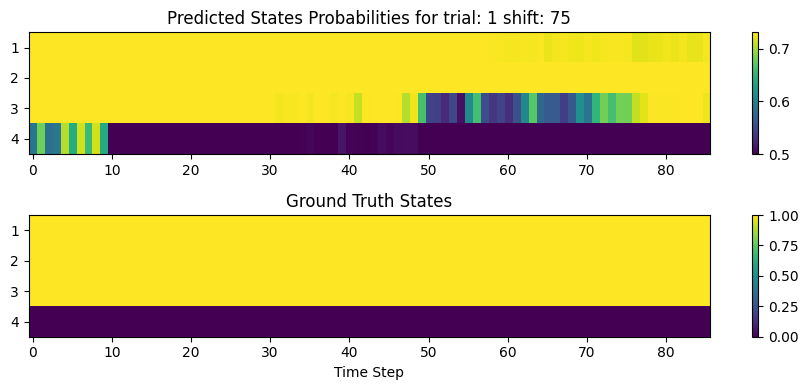

Epoch 0, train loss: 0.7071592807769775, train acc: 0.5725353476660856
Epoch 10, train loss: 0.2734655737876892, train acc: 0.9184098392407515
Epoch 20, train loss: 0.1693277359008789, train acc: 0.9409742397830718
Epoch 30, train loss: 0.12294687330722809, train acc: 0.9563238427270967
Epoch 40, train loss: 0.09383078664541245, train acc: 0.9671218283943444
Epoch 50, train loss: 0.07393504679203033, train acc: 0.9755955839628123
Epoch 60, train loss: 0.05772687494754791, train acc: 0.9837788107689328
Epoch 70, train loss: 0.04770304262638092, train acc: 0.9841661824520628
Epoch 80, train loss: 0.03932902589440346, train acc: 0.9888146426496223
Epoch 90, train loss: 0.032922323793172836, train acc: 0.9902672864613596
Epoch 100, train loss: 0.029103204607963562, train acc: 0.991913616114662
Epoch 110, train loss: 0.024656547233462334, train acc: 0.9936083672283557
Epoch 120, train loss: 0.025153329595923424, train acc: 0.9930757311640519
Epoch 130, train loss: 0.019327517598867416, trai

<Figure size 640x480 with 0 Axes>

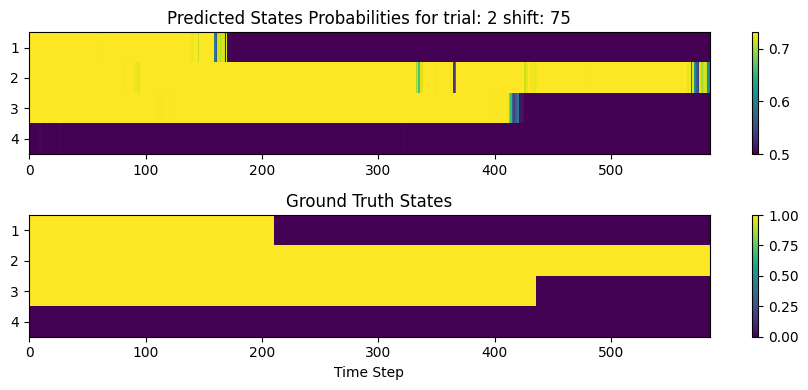

Epoch 0, train loss: 0.7837954759597778, train acc: 0.34624652455977756
Epoch 10, train loss: 0.2897906005382538, train acc: 0.9176088971269695
Epoch 20, train loss: 0.1723816841840744, train acc: 0.9461075069508804
Epoch 30, train loss: 0.1207619309425354, train acc: 0.9571825764596849
Epoch 40, train loss: 0.09312937408685684, train acc: 0.9672381835032438
Epoch 50, train loss: 0.07510846853256226, train acc: 0.9755792400370714
Epoch 60, train loss: 0.06158553063869476, train acc: 0.980259499536608
Epoch 70, train loss: 0.050721075385808945, train acc: 0.9839666357738647
Epoch 80, train loss: 0.04322859272360802, train acc: 0.9860055607043559
Epoch 90, train loss: 0.03567979857325554, train acc: 0.9889249304911956
Epoch 100, train loss: 0.030249591916799545, train acc: 0.9913345690454124
Epoch 110, train loss: 0.02717231772840023, train acc: 0.9916589434661723
Epoch 120, train loss: 0.023018820211291313, train acc: 0.9935125115848007
Epoch 130, train loss: 0.020046358928084373, train

<Figure size 640x480 with 0 Axes>

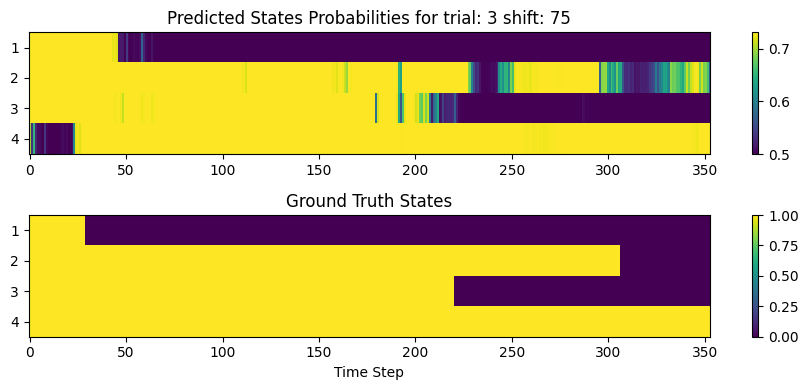

Epoch 0, train loss: 0.7058250308036804, train acc: 0.5372538089929394
Epoch 10, train loss: 0.26795873045921326, train acc: 0.920661464139725
Epoch 20, train loss: 0.1577635407447815, train acc: 0.9459308807134894
Epoch 30, train loss: 0.11098139733076096, train acc: 0.9596339650687477
Epoch 40, train loss: 0.08399302512407303, train acc: 0.9695280564845782
Epoch 50, train loss: 0.06701499223709106, train acc: 0.9785395763656634
Epoch 60, train loss: 0.05439521744847298, train acc: 0.9844388703084356
Epoch 70, train loss: 0.045740365982055664, train acc: 0.9853214418431809
Epoch 80, train loss: 0.041138410568237305, train acc: 0.9863433667781494
Epoch 90, train loss: 0.034115877002477646, train acc: 0.9900130063173541
Epoch 100, train loss: 0.030010882765054703, train acc: 0.9912671869193609
Epoch 110, train loss: 0.027751805260777473, train acc: 0.9918246005202527
Epoch 120, train loss: 0.024197598919272423, train acc: 0.9921497584541062
Epoch 130, train loss: 0.02161986753344536, tr

<Figure size 640x480 with 0 Axes>

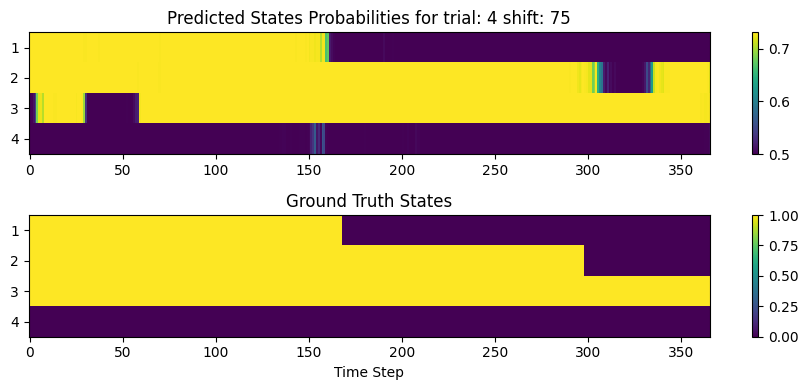

Epoch 0, train loss: 0.6620787382125854, train acc: 0.5773877473363774
Epoch 10, train loss: 0.24978503584861755, train acc: 0.9302701674277016
Epoch 20, train loss: 0.16380788385868073, train acc: 0.9413527397260274
Epoch 30, train loss: 0.11770910769701004, train acc: 0.9570966514459666
Epoch 40, train loss: 0.08941328525543213, train acc: 0.967941400304414
Epoch 50, train loss: 0.071291483938694, train acc: 0.9741723744292238
Epoch 60, train loss: 0.0581500381231308, train acc: 0.9809741248097412
Epoch 70, train loss: 0.047764234244823456, train acc: 0.9853976407914764
Epoch 80, train loss: 0.0398380272090435, train acc: 0.9878234398782344
Epoch 90, train loss: 0.038509439677000046, train acc: 0.985730593607306
Epoch 100, train loss: 0.03114030882716179, train acc: 0.9899638508371386
Epoch 110, train loss: 0.026683839038014412, train acc: 0.9915334855403348
Epoch 120, train loss: 0.024902859702706337, train acc: 0.992056697108067
Epoch 130, train loss: 0.022099178284406662, train ac

<Figure size 640x480 with 0 Axes>

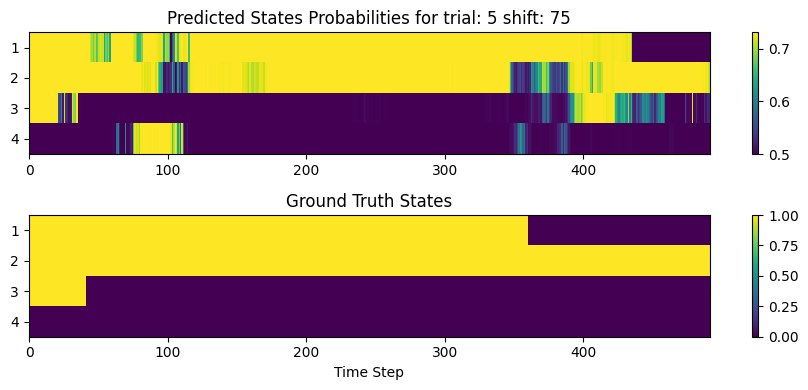

Epoch 0, train loss: 0.8036419749259949, train acc: 0.45949855351976854
Epoch 10, train loss: 0.3058505654335022, train acc: 0.9158630665380907
Epoch 20, train loss: 0.1766141802072525, train acc: 0.9449855351976856
Epoch 30, train loss: 0.11381526291370392, train acc: 0.9593539054966249
Epoch 40, train loss: 0.0849280059337616, train acc: 0.9696239151398264
Epoch 50, train loss: 0.06679493188858032, train acc: 0.9760848601735777
Epoch 60, train loss: 0.0542108491063118, train acc: 0.9824011571841852
Epoch 70, train loss: 0.04633389413356781, train acc: 0.9846673095467695
Epoch 80, train loss: 0.03743996098637581, train acc: 0.9886210221793635
Epoch 90, train loss: 0.0316058024764061, train acc: 0.991321118611379
Epoch 100, train loss: 0.027817517518997192, train acc: 0.99175506268081
Epoch 110, train loss: 0.0237543024122715, train acc: 0.9939729990356798
Epoch 120, train loss: 0.020772237330675125, train acc: 0.9942622950819672
Epoch 130, train loss: 0.017692452296614647, train acc: 

<Figure size 640x480 with 0 Axes>

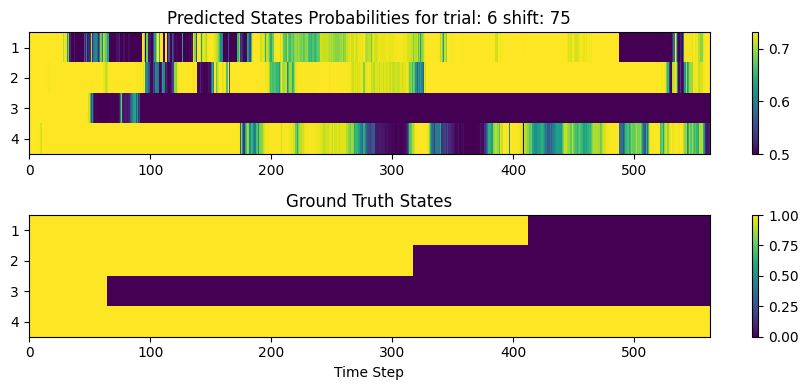

Epoch 0, train loss: 0.7019845247268677, train acc: 0.5927660807417423
Epoch 10, train loss: 0.2648370862007141, train acc: 0.9275159358701951
Epoch 20, train loss: 0.16164767742156982, train acc: 0.9450936836005408
Epoch 30, train loss: 0.11649404466152191, train acc: 0.956973150473247
Epoch 40, train loss: 0.08878394961357117, train acc: 0.9675004829051574
Epoch 50, train loss: 0.06993433088064194, train acc: 0.9767239714120147
Epoch 60, train loss: 0.05867046117782593, train acc: 0.9824222522696543
Epoch 70, train loss: 0.047806788235902786, train acc: 0.9855611357929303
Epoch 80, train loss: 0.04027293249964714, train acc: 0.9876859184856094
Epoch 90, train loss: 0.03389517217874527, train acc: 0.9900038632412594
Epoch 100, train loss: 0.033708974719047546, train acc: 0.9897141201468032
Epoch 110, train loss: 0.026964588090777397, train acc: 0.9920320649024531
Epoch 120, train loss: 0.02386127971112728, train acc: 0.993384199343249
Epoch 130, train loss: 0.02104467712342739, train 

<Figure size 640x480 with 0 Axes>

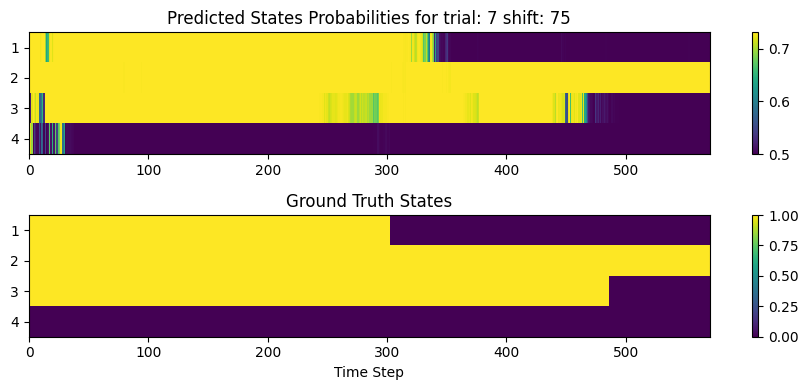

Epoch 0, train loss: 0.6736878156661987, train acc: 0.5555708769994484
Epoch 10, train loss: 0.26290568709373474, train acc: 0.9310075381503953
Epoch 20, train loss: 0.15500423312187195, train acc: 0.9525188453759882
Epoch 30, train loss: 0.10744974762201309, train acc: 0.9606545320831035
Epoch 40, train loss: 0.08104657381772995, train acc: 0.9731568302996875
Epoch 50, train loss: 0.06394072622060776, train acc: 0.9776153704725133
Epoch 60, train loss: 0.05157264322042465, train acc: 0.9852454495311638
Epoch 70, train loss: 0.04260410740971565, train acc: 0.987865416436845
Epoch 80, train loss: 0.03552563488483429, train acc: 0.9896580253723111
Epoch 90, train loss: 0.031752075999975204, train acc: 0.989428203713918
Epoch 100, train loss: 0.02828732132911682, train acc: 0.991588527302813
Epoch 110, train loss: 0.02499374747276306, train acc: 0.992553778268064
Epoch 120, train loss: 0.022411083802580833, train acc: 0.9938867438867439
Epoch 130, train loss: 0.020500311627984047, train a

<Figure size 640x480 with 0 Axes>

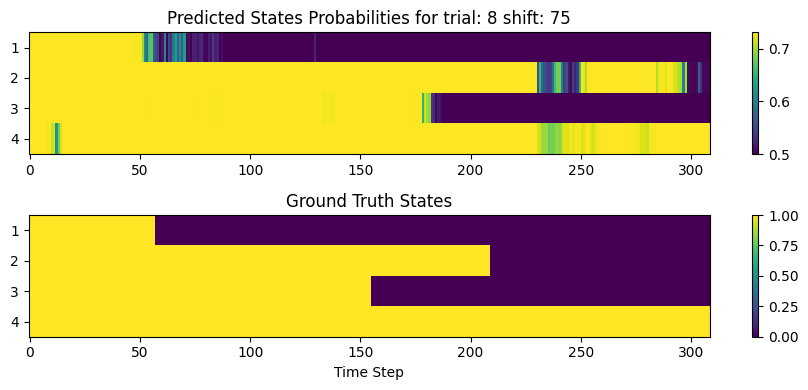

Epoch 0, train loss: 0.6366026401519775, train acc: 0.6048371647509578
Epoch 10, train loss: 0.25252479314804077, train acc: 0.9184865900383141
Epoch 20, train loss: 0.1508815586566925, train acc: 0.950095785440613
Epoch 30, train loss: 0.10513219237327576, train acc: 0.9600574712643678
Epoch 40, train loss: 0.07830911129713058, train acc: 0.973323754789272
Epoch 50, train loss: 0.06092016398906708, train acc: 0.9795498084291188
Epoch 60, train loss: 0.050118111073970795, train acc: 0.9846264367816092
Epoch 70, train loss: 0.04106232896447182, train acc: 0.987212643678161
Epoch 80, train loss: 0.03508233278989792, train acc: 0.9889367816091954
Epoch 90, train loss: 0.033022522926330566, train acc: 0.9896072796934866
Epoch 100, train loss: 0.027208229526877403, train acc: 0.9919540229885058
Epoch 110, train loss: 0.023433586582541466, train acc: 0.9922413793103448
Epoch 120, train loss: 0.020514249801635742, train acc: 0.9937260536398468
Epoch 130, train loss: 0.020950131118297577, trai

<Figure size 640x480 with 0 Axes>

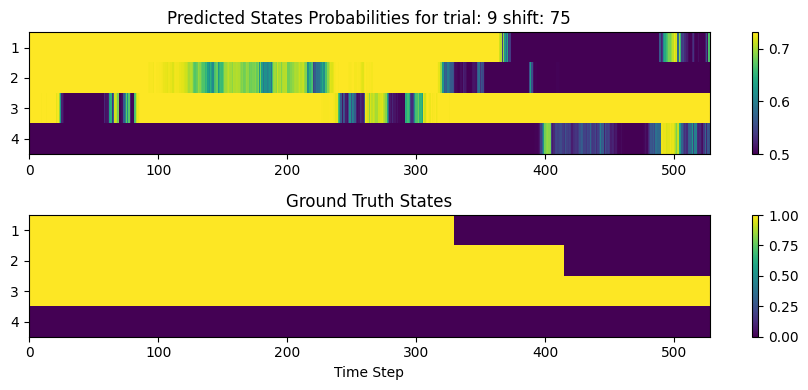

Epoch 0, train loss: 0.7136492729187012, train acc: 0.5215791386516445
Epoch 10, train loss: 0.25605595111846924, train acc: 0.9312193349082318
Epoch 20, train loss: 0.15582464635372162, train acc: 0.9496638197346902
Epoch 30, train loss: 0.11264082044363022, train acc: 0.95852262402326
Epoch 40, train loss: 0.08647489547729492, train acc: 0.9701980737779393
Epoch 50, train loss: 0.06810665130615234, train acc: 0.9774214065055424
Epoch 60, train loss: 0.05675748363137245, train acc: 0.9821006723605307
Epoch 70, train loss: 0.0464436300098896, train acc: 0.9863256405596947
Epoch 80, train loss: 0.04048573598265648, train acc: 0.9871433763401781
Epoch 90, train loss: 0.03472857549786568, train acc: 0.9890968562602217
Epoch 100, train loss: 0.030726177617907524, train acc: 0.9906868980556061
Epoch 110, train loss: 0.02641972154378891, train acc: 0.9923677993821551
Epoch 120, train loss: 0.023282155394554138, train acc: 0.9931855351626385
Epoch 130, train loss: 0.021751539781689644, train 

<Figure size 640x480 with 0 Axes>

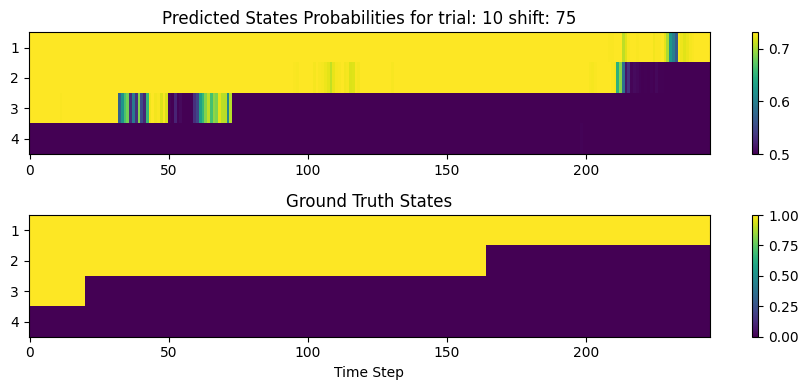

Epoch 0, train loss: 0.7174057364463806, train acc: 0.47529953917050694
Epoch 10, train loss: 0.254858136177063, train acc: 0.9247465437788018
Epoch 20, train loss: 0.1508757770061493, train acc: 0.9488018433179723
Epoch 30, train loss: 0.10730702430009842, train acc: 0.9591244239631337
Epoch 40, train loss: 0.07967270910739899, train acc: 0.9721198156682027
Epoch 50, train loss: 0.06465775519609451, train acc: 0.9782488479262673
Epoch 60, train loss: 0.05318780243396759, train acc: 0.9834562211981567
Epoch 70, train loss: 0.04394877329468727, train acc: 0.986589861751152
Epoch 80, train loss: 0.03811866044998169, train acc: 0.9887557603686636
Epoch 90, train loss: 0.03407130762934685, train acc: 0.9902764976958526
Epoch 100, train loss: 0.02871517278254032, train acc: 0.9917972350230415
Epoch 110, train loss: 0.02552798017859459, train acc: 0.9920276497695852
Epoch 120, train loss: 0.023857051506638527, train acc: 0.9917511520737328
Epoch 130, train loss: 0.020768359303474426, train a

<Figure size 640x480 with 0 Axes>

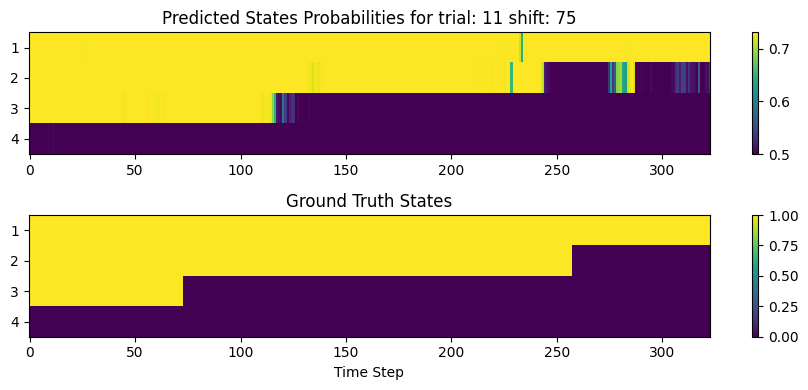

Epoch 0, train loss: 0.8150132894515991, train acc: 0.40156221450758267
Epoch 10, train loss: 0.2926435172557831, train acc: 0.9131189475607527
Epoch 20, train loss: 0.16985288262367249, train acc: 0.9417595468664353
Epoch 30, train loss: 0.11468695104122162, train acc: 0.9566508313539193
Epoch 40, train loss: 0.08682993054389954, train acc: 0.9659236250685181
Epoch 50, train loss: 0.06861952692270279, train acc: 0.9751507399963457
Epoch 60, train loss: 0.05666881054639816, train acc: 0.9805408368353736
Epoch 70, train loss: 0.04791523516178131, train acc: 0.9850173579389732
Epoch 80, train loss: 0.042017970234155655, train acc: 0.9873469760643158
Epoch 90, train loss: 0.03637738898396492, train acc: 0.9880778366526585
Epoch 100, train loss: 0.03255857899785042, train acc: 0.9899506669102869
Epoch 110, train loss: 0.02833808958530426, train acc: 0.9917778183811438
Epoch 120, train loss: 0.02614736743271351, train acc: 0.991046957792801
Epoch 130, train loss: 0.023428307846188545, train

<Figure size 640x480 with 0 Axes>

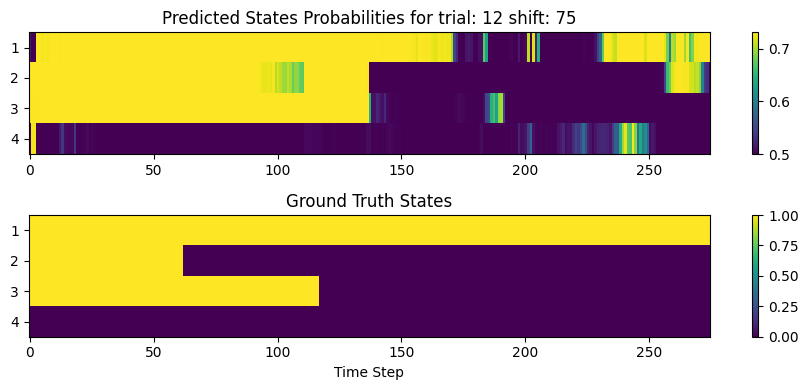

Epoch 0, train loss: 0.7674189805984497, train acc: 0.5172701949860724
Epoch 10, train loss: 0.26643630862236023, train acc: 0.9233983286908078
Epoch 20, train loss: 0.1573415994644165, train acc: 0.9507428040854224
Epoch 30, train loss: 0.11255685240030289, train acc: 0.9592850510677808
Epoch 40, train loss: 0.08585356920957565, train acc: 0.970380687093779
Epoch 50, train loss: 0.06785898655653, train acc: 0.9763231197771588
Epoch 60, train loss: 0.056671131402254105, train acc: 0.982544103992572
Epoch 70, train loss: 0.04789562523365021, train acc: 0.9858402971216341
Epoch 80, train loss: 0.0413082130253315, train acc: 0.9865366759517178
Epoch 90, train loss: 0.03563932329416275, train acc: 0.9890436397400185
Epoch 100, train loss: 0.032410841435194016, train acc: 0.9904828226555246
Epoch 110, train loss: 0.02834826335310936, train acc: 0.9919220055710306
Epoch 120, train loss: 0.024736231192946434, train acc: 0.9928505106778087
Epoch 130, train loss: 0.023380905389785767, train acc

<Figure size 640x480 with 0 Axes>

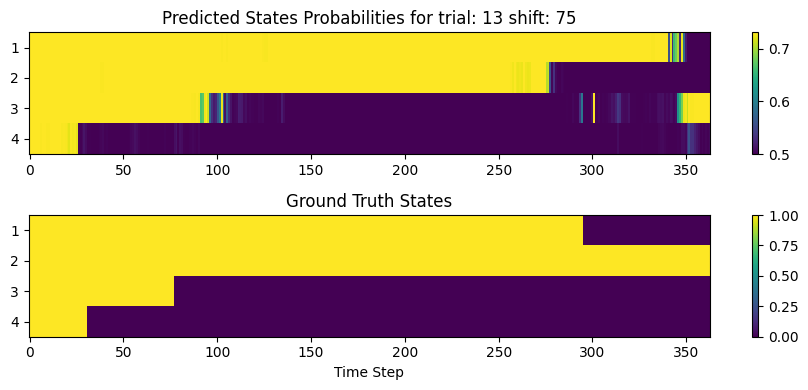

Epoch 0, train loss: 0.7891828417778015, train acc: 0.3811336717428088
Epoch 10, train loss: 0.2930104732513428, train acc: 0.9069843955630758
Epoch 20, train loss: 0.16709597408771515, train acc: 0.9532336905433352
Epoch 30, train loss: 0.11130543053150177, train acc: 0.9628219590148525
Epoch 40, train loss: 0.08181430399417877, train acc: 0.9727392366986276
Epoch 50, train loss: 0.06296934932470322, train acc: 0.9799304380522654
Epoch 60, train loss: 0.04955514892935753, train acc: 0.9855235946606505
Epoch 70, train loss: 0.042341649532318115, train acc: 0.986322617033277
Epoch 80, train loss: 0.03521979972720146, train acc: 0.9892836999435984
Epoch 90, train loss: 0.03147992864251137, train acc: 0.9900827223162249
Epoch 100, train loss: 0.028515756130218506, train acc: 0.9906937394247038
Epoch 110, train loss: 0.024493098258972168, train acc: 0.9930908065425832
Epoch 120, train loss: 0.021869469434022903, train acc: 0.9936548223350253
Epoch 130, train loss: 0.020388370379805565, tra

<Figure size 640x480 with 0 Axes>

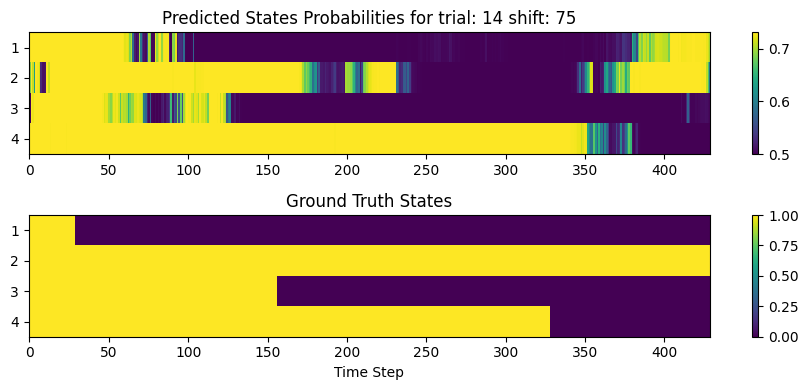

Epoch 0, train loss: 0.7288268804550171, train acc: 0.4752186588921283
Epoch 10, train loss: 0.27105191349983215, train acc: 0.9222394314868805
Epoch 20, train loss: 0.1586417704820633, train acc: 0.9462919096209913
Epoch 30, train loss: 0.11155066639184952, train acc: 0.9577715014577259
Epoch 40, train loss: 0.08667275309562683, train acc: 0.967884475218659
Epoch 50, train loss: 0.07011166960000992, train acc: 0.9766763848396501
Epoch 60, train loss: 0.05911592021584511, train acc: 0.9806395772594753
Epoch 70, train loss: 0.04936900734901428, train acc: 0.9838739067055393
Epoch 80, train loss: 0.04337448254227638, train acc: 0.985923833819242
Epoch 90, train loss: 0.037955209612846375, train acc: 0.987518221574344
Epoch 100, train loss: 0.03182128444314003, train acc: 0.9903425655976676
Epoch 110, train loss: 0.03186618536710739, train acc: 0.9896137026239067
Epoch 120, train loss: 0.026547133922576904, train acc: 0.9910714285714286
Epoch 130, train loss: 0.02307448908686638, train ac

<Figure size 640x480 with 0 Axes>

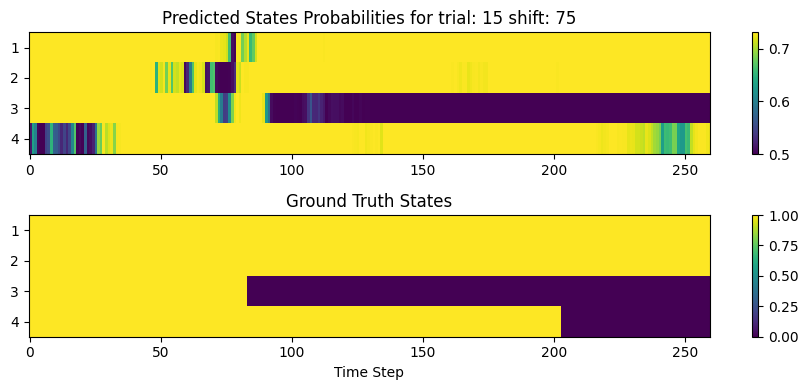

<Figure size 640x480 with 0 Axes>

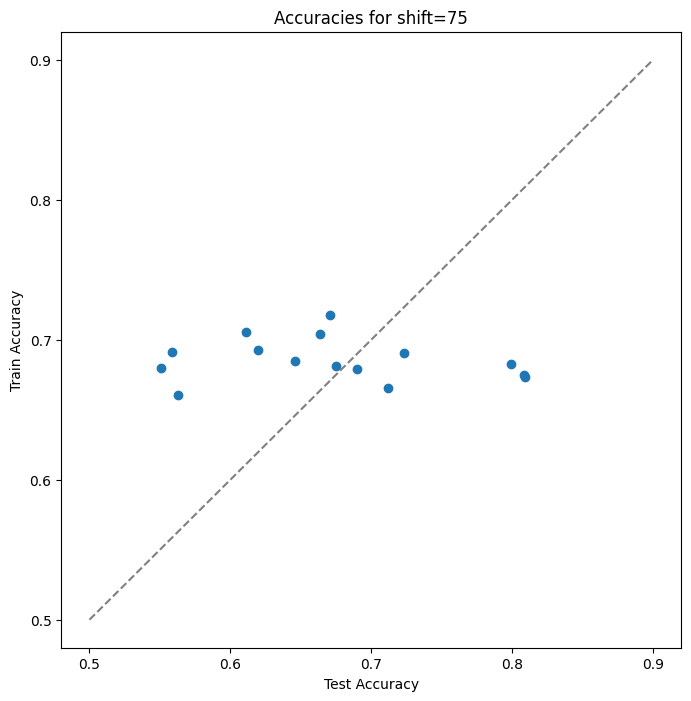

<Figure size 640x480 with 0 Axes>

In [39]:
# Hyperparameters
input_dim = 64
output_dim = 4
num_layers = 1
cmap = "viridis"

columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']

df_human = pd.read_csv("data_human_jarvis.csv")
df_human = df_human.drop(columns=['H_id','s_1','s_2','s_3','s_4'])
file = "data_model_v3.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)

labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial','H_trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['id','trial']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift



probs_dict_mh = {}
hidden_states_dict = {}
test_predictions_dict_smh = {}
test_probs_dict_smh = {}
train_probs_dict_smh = {}
train_predictions_dict_smh = {}
train_accs_all = []
test_accs_all = []

for j in np.arange(1,16):    
    shift = 75
    set_values = j
    k = set_values - 1
    num_layers = 1
    hidden_dim = 40
    n_epochs = 600
    lr = 0.01
    model_name = 's_m_h_'+str(set_values)+"_"+str(n_epochs)+"_"+str(hidden_dim)+"_"+str(num_layers)+"_"+str(lr)+"_"
    # Create an instance of GRUCellNet
    model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

    # Define loss function and optimizer
    class_weights = torch.tensor([1.8]).to(device)
    loss_fn = nn.BCELoss()  
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)
    

    selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
            'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
            'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
            'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
            'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
            'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
            'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
            'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
            'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
            'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
            'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
            'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
            'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
            'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
            'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
            'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
        'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X, y = full_set.drop(columns=labels), full_set[labels]
    
    # reset index 
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

    # Create custom datasets for training, validation, and testing
    full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
    train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
    test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

    fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
    train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


    train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
        train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
    
                # Specify the folder path and the model filename
    folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_hypertuning/' 
    model_filename = model_name + '.pth'  
    state_dict = model.state_dict()

    # Combine the folder path and model filename
    full_model = os.path.join(folder_path, model_filename)

    # Save the model to the specified folder
    torch.save(state_dict, full_model)
    
    model.eval()  # Set the model to evaluation mode
    # Initialize an empty list to store predictions
    test_preds = []
    test_probs = []
    train_probs = []
    train_preds = []
    
    # Iterate through the test data batches
    for inputs, _ in test_dataloader:
        inputs = inputs.float()
        # Forward pass to get predictions
        with torch.no_grad():
            predictions, f,f = model(inputs)
            probabilities = torch.sigmoid(predictions)
            preds = torch.round(probabilities)

        # Append predictions to the list
        test_preds.append(preds)
        test_probs.append(probabilities)

    # Concatenate the predicted batches
    test_preds = torch.cat(test_preds, dim=0)
    test_probs = torch.cat(test_probs, dim=0)

    test_preds_array = test_preds.numpy()
    test_probs_array = test_probs.numpy()
    
    # Iterate through the test data batches
    for inputs, _ in train_dataloader:
        inputs = inputs.float()
        # Forward pass to get predictions
        with torch.no_grad():
            predictions, f,f = model(inputs)
            probabilities = torch.sigmoid(predictions)
            preds = torch.round(probabilities)

        # Append predictions to the list
        train_preds.append(preds)
        train_probs.append(probabilities)

    # Concatenate the predicted batches
    train_preds = torch.cat(train_preds, dim=0)
    train_probs = torch.cat(train_probs, dim=0)

    train_preds_array = train_preds.numpy()
    train_probs_array = train_probs.numpy()

    columns = ['s_1','s_2','s_3','s_4']
    test_probs_df = pd.DataFrame(test_probs_array)
    train_probs_df = pd.DataFrame(train_probs_array)
    train_probs_df.columns = columns
    test_probs_df.columns = columns 
    # Convert the tensor of predictions to a DataFrame
    test_preds_df = pd.DataFrame(test_preds_array, columns=y_test.columns, index=y_test.index)
    train_preds_df = pd.DataFrame(train_preds_array, columns=y_train.columns, index=y_train.index)
    # Calculate accuracy for each output state
    test_accuracies = (test_preds_df == y_test).mean()
    train_accuracies = (train_preds_df == y_train).mean()
    # Construct the key for the combination
    key = f"smh_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
    test_predictions_dict_smh[key] = test_preds_array 
    test_probs_dict_smh[key] = test_probs_array 
    
    train_predictions_dict_smh[key] = train_preds_array
    train_probs_dict_smh[key] = train_probs_array
    
    print(model_name)
    print("Accuracy for each output state in",model_name)
    print(np.mean(test_accuracies))
    test_accs = np.mean(test_accuracies)
    train_accs = np.mean(train_accuracies)
    
    test_accs_all.append(test_accs)
    train_accs_all.append(train_accs)
    
    #spec = specificity(y_test.values, test_preds_df.values)
    #print(spec)
    file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/predictions/solo_model/" + str(model_name) + "_test_probs.csv"
    np.savetxt(file_path, test_probs_array, delimiter=',')
    file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/predictions/solo_model/" + str(model_name) + "_train_probs.csv"
    np.savetxt(file_path,train_probs_array,delimiter=',')
    
    
        # Specify the name of the folder you want to create
    
    folder_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/"
    
    
    file_name = 'results_smh.txt'
    file_path = folder_path + file_name  # Replace with your desired file path
    value_to_save = model_name+"_"+str(test_accs)  # Replace with the value you want to save

    try:
        with open(file_path, "a") as file:
            # 2. Write the value to the file
            file.write(value_to_save)
            print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
        
    keys_list = list(test_probs_dict_mh.keys())
    trial_key = keys_list[k]
    y_hat = test_probs_dict_mh[trial_key]
    y_labels = ['1', '2', '3', '4']

    # Create a figure with a grid of subplots (2 rows, 1 column)
    fig, axs = plt.subplots(2,1, figsize=(9,4))

    # Create the first heatmap plot in the first subplot
    heatmap1 = axs[0].imshow(test_probs_array.T, cmap=cmap, aspect='auto', interpolation='none')

    # Add colorbar to the first heatmap subplot
    cbar1 = plt.colorbar(heatmap1, ax=axs[0])
    # Set the axis labels and title for the first heatmap subplot
    #axs[0].set_xlabel('Time Step')
    #axs[0].set_ylabel('Predicted State')
    axs[0].set_title('Predicted States Probabilities for trial: '+ str(set_values) + " " + "shift: " + str(shift))

    # Set the y-axis ticks and labels for the first heatmap subplot
    axs[0].set_yticks(np.arange(len(y_labels)))
    axs[0].set_yticklabels(y_labels)





    # Set the axis labels and title for the second heatmap subplot
    axs[1].set_xlabel('Time Step')
    #axs[1].set_ylabel('Predicted State')
    axs[1].set_title('Ground Truth States')
        # Create the second heatmap plot in the second subplot
    heatmap2 = axs[1].imshow(y_test.T, cmap=cmap, aspect='auto', interpolation='none')
    # Add colorbar to the second heatmap subplot
    cbar2 = plt.colorbar(heatmap2, ax=axs[1])
    # Set the y-axis ticks and labels for the second heatmap subplot
    axs[1].set_yticks(np.arange(len(y_labels)))
    axs[1].set_yticklabels(y_labels)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plot_name = str(model_name)+'_heatmap_v3.png'
    plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/new_heatmaps/'+plot_name)

    plt.show()
    plt.clf()
    
    
plt.figure(figsize=(8, 8))
scatter_plot = plt.scatter(test_accs_all, train_accs_all)
plt.xlabel('Test Accuracy')
plt.ylabel('Train Accuracy')
#plt.axis('equal')
plt.title("Accuracies for shift=75")
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.plot([0.5, 0.9], [0.5, 0.9], linestyle='--', color='gray')
plt.show()
plot_name = str(model_name)+'_accuracy.png'
plt.show()
plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/new_heatmaps/'+plot_name)

#plt.clf()   
    
            
            
        

In [ ]:
# Hyperparameters
input_dim = 60
hidden_dim = 42
output_dim = 4
num_layers = 1
n_epochs =101
lr = 0.1

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)

In [ ]:
hidden_states_dict = {}
predictions_dict_mh = {}
for l in np.arange(1,10):
    for j in np.arange(1,16):
        #for i in np.arange(10,151,step=10):
        for i in np.arange(50,126,step=25):    
            shift = i
            set_values = j
            
            num_layers = l
            n_epochs =150
            lr = 0.1
            model_name = 'm_h'+str(shift)+'_'+'val'+str(set_values)+"_"+str(num_layers)
            # Create an instance of GRUCellNet
            model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

            # Define loss function and optimizer
            class_weights = torch.tensor([1.8]).to(device)
            loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)


            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in scaled_df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_minus_' + str(shift)
                    trial_df[new_col_name] = trial_df[col].shift(shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = shifted_df.append(trial_df, ignore_index=True)
            
        
            selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
            'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
            'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
            'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
            'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
            'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
            'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
            'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
            'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
            'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
            'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
            'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
            'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
            'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
            'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
            'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
        'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
            shifted_df = shifted_df[selected_columns]
            # Step 5: Split the data into training and test sets based on the 'trial' column
            # Step 5: Split the data into training and test sets based on the 'trial' column
            train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
            test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
            full_set = shifted_df.drop(columns=['id','trial'])

            # split data into x and y 
            X_train, y_train = train_set.drop(columns=labels), train_set[labels]
            X_test, y_test = test_set.drop(columns=labels), test_set[labels]
            X, y = full_set.drop(columns=labels), full_set[labels]
            
            # reset index 
            X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
            X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
            X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

            # Create custom datasets for training, validation, and testing
            full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
            train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
            test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

            fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
            train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
            test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


            train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
                train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
            
            
            state_dict = model.state_dict()

            # Specify the folder path and the model filename
            folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_gradient/' 
            model_filename = model_name + '.pth'  

            # Combine the folder path and model filename
            full_model = os.path.join(folder_path, model_filename)

            # Save the model to the specified folder
            torch.save(state_dict, full_model)


            
            model.eval()  # Set the model to evaluation mode
            # Initialize an empty list to store predictions
            all_preds = []
            all_probs = []
            

            # Iterate through the test data batches
            for inputs, _ in test_dataloader:
                inputs = inputs.float()
                # Forward pass to get predictions
                with torch.no_grad():
                    predictions, f,f = model(inputs)
                    probabilities = torch.sigmoid(predictions)
                    preds = torch.round(probabilities)

                # Append predictions to the list
                all_preds.append(preds)
                all_probs.append(probabilities)

            # Concatenate the predicted batches
            all_preds = torch.cat(all_preds, dim=0)
            all_probs = torch.cat(all_probs, dim=0)

            all_preds_array = all_preds.numpy()
            all_probs_array = all_probs.numpy()


            columns = ['s_1','s_2','s_3','s_4']
            all_probs_df = pd.DataFrame(all_probs_array)
            all_probs_df.columns = columns
            # Convert the tensor of predictions to a DataFrame
            predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
            # Calculate accuracy for each output state
            accuracies = (predictions_df == y_test).mean()
            # Construct the key for the combination
            key = f"mh_shift{shift}_set{set_values}"

            # Store the predictions as NumPy arrays in the dictionary
            predictions_dict_mh[key] = all_preds_array 

            print(model_name)
            print("Accuracy for each output state in",model_name)
            print(np.mean(accuracies))
            test_accs = np.mean(accuracies)
            file_name = 'results_layers_test.txt'
            file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/" + file_name  # Replace with your desired file path
            value_to_save = model_name+": "+str(test_accs)  # Replace with the value you want to save

            try:
                with open(file_path, "a") as file:
                    # 2. Write the value to the file
                    file.write(value_to_save)
                    print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
            except Exception as e:
                print(f"An error occurred: {e}")

In [140]:
# Hyperparameters
input_dim = 64
hidden_dim = 44
output_dim = 4
num_layers = 1
lr = 0.1


columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']

df_human = pd.read_csv("data_human_jarvis.csv")
df_human = df_human.drop(columns=['H_id','s_1','s_2','s_3','s_4'])
file = "data_model_v3.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)

labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial','H_trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['id','trial']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift



probs_dict_smh = {}
hidden_states_dict = {}
test_predictions_dict_smh = {}
test_probs_dict_smh = {}
train_probs_dict_smh = {}
train_predictions_dict_smh = {}
train_accs_all = []
test_accs_all = []
for l in [0.01,0.001,0.0001]:
    for h in np.arange(26,30):
        for j in np.arange(1,16):    
            shift = 75
            set_values = j
            num_layers = 1
            hidden_dim = h 
            n_epochs = 600
            lr = l
            model_name = 'm_h_'+str(set_values)+"_"+str(n_epochs)+"_"+str(hidden_dim)+"_"+str(num_layers)+"_"+str(lr)
            # Create an instance of GRUCellNet
            model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

            # Define loss function and optimizer
            class_weights = torch.tensor([1.8]).to(device)
            loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)


            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in scaled_df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_minus_' + str(shift)
                    trial_df[new_col_name] = trial_df[col].shift(shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = shifted_df.append(trial_df, ignore_index=True)
            

            selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
            'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
            'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
            'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
            'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
            'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
            'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
            'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
            'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
            'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
            'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
            'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
            'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
            'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
            'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
            'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
        'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift),'s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift)]
            shifted_df = shifted_df[selected_columns]
            # Step 5: Split the data into training and test sets based on the 'trial' column
            # Step 5: Split the data into training and test sets based on the 'trial' column
            train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
            test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
            full_set = shifted_df.drop(columns=['id','trial'])

            # split data into x and y 
            X_train, y_train = train_set.drop(columns=labels), train_set[labels]
            X_test, y_test = test_set.drop(columns=labels), test_set[labels]
            X, y = full_set.drop(columns=labels), full_set[labels]
            
            # reset index 
            X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
            X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
            X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

            # Create custom datasets for training, validation, and testing
            full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
            train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
            test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

            fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
            train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
            test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


            train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
                train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
            
            model.eval()  # Set the model to evaluation mode
            # Initialize an empty list to store predictions
            test_preds = []
            test_probs = []
            train_probs = []
            train_preds = []
            
            # Iterate through the test data batches
            for inputs, _ in test_dataloader:
                inputs = inputs.float()
                print("Sequence Length:", inputs.size(1))
                # Forward pass to get predictions
                with torch.no_grad():
                    predictions, f,f = model(inputs)
                    probabilities = torch.sigmoid(predictions)
                    preds = torch.round(probabilities)

                # Append predictions to the list
                test_preds.append(preds)
                test_probs.append(probabilities)

            # Concatenate the predicted batches
            test_preds = torch.cat(test_preds, dim=0)
            test_probs = torch.cat(test_probs, dim=0)

            test_preds_array = test_preds.numpy()
            test_probs_array = test_probs.numpy()
            
            # Iterate through the test data batches
            for inputs, _ in train_dataloader:
                inputs = inputs.float()
                # Forward pass to get predictions
                with torch.no_grad():
                    predictions, f,f = model(inputs)
                    probabilities = torch.sigmoid(predictions)
                    preds = torch.round(probabilities)

                # Append predictions to the list
                train_preds.append(preds)
                train_probs.append(probabilities)

            # Concatenate the predicted batches
            train_preds = torch.cat(train_preds, dim=0)
            train_probs = torch.cat(train_probs, dim=0)

            train_preds_array = train_preds.numpy()
            train_probs_array = train_probs.numpy()

            columns = ['s_1','s_2','s_3','s_4']
            test_probs_df = pd.DataFrame(test_probs_array)
            train_probs_df = pd.DataFrame(train_probs_array)
            train_probs_df.columns = columns
            test_probs_df.columns = columns 
            # Convert the tensor of predictions to a DataFrame
            test_preds_df = pd.DataFrame(test_preds_array, columns=y_test.columns, index=y_test.index)
            train_preds_df = pd.DataFrame(train_preds_array, columns=y_train.columns, index=y_train.index)
            # Calculate accuracy for each output state
            test_accuracies = (test_preds_df == y_test).mean()
            train_accuracies = (train_preds_df == y_train).mean()
            # Construct the key for the combination
            key = f"smh_shift{shift}_set{set_values}"

            # Store the predictions as NumPy arrays in the dictionary
            test_predictions_dict_smh[key] = test_preds_array 
            test_probs_dict_smh[key] = test_probs_array 
            
            train_predictions_dict_smh[key] = train_preds_array
            train_probs_dict_smh[key] = train_probs_array
            
            print(model_name)
            print("Accuracy for each output state in",model_name)
            print(np.mean(test_accuracies))
            test_accs = np.mean(test_accuracies)
            train_accs = np.mean(train_accuracies)
            
            test_accs_all.append(test_accs)
            train_accs_all.append(train_accs)
            
            file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/predictions/dyadic_model/" + str(model_name) + "_test_probs.csv"
            np.savetxt(file_path, test_probs_array, delimiter=',')
            file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/predictions/dyadic_model/" + str(model_name) + "_train_probs.csv"
            np.savetxt(file_path,train_probs_array,delimiter=',')
            
            
                # Specify the name of the folder you want to create
            
            folder_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/"
            
            
            file_name = 'results_smh.txt'
            file_path = folder_path + file_name  # Replace with your desired file path
            value_to_save = model_name+"_"+str(test_accs)  # Replace with the value you want to save

            try:
                with open(file_path, "a") as file:
                    # 2. Write the value to the file
                    file.write(value_to_save)
                    print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
            except Exception as e:
                print(f"An error occurred: {e}")
            

        
            
        

Epoch 0, train loss: 0.9015352725982666, train acc: 0.5423878488166726
Epoch 10, train loss: 0.7403231859207153, train acc: 0.9187566231013776
Epoch 20, train loss: 0.6866490244865417, train acc: 0.9447191805015895
Epoch 30, train loss: 0.6659778356552124, train acc: 0.9513864358883787
Epoch 40, train loss: 0.6574854254722595, train acc: 0.9554927587424938
Epoch 50, train loss: 0.6528124809265137, train acc: 0.9588484634404804
Epoch 60, train loss: 0.6490878462791443, train acc: 0.963528788413988
Epoch 70, train loss: 0.6454926133155823, train acc: 0.9680766513599435
Epoch 80, train loss: 0.6426294445991516, train acc: 0.9719180501589544
Epoch 90, train loss: 0.6402950286865234, train acc: 0.9766866831508301
Epoch 100, train loss: 0.6384122371673584, train acc: 0.9793359237018722
Epoch 110, train loss: 0.636732280254364, train acc: 0.9823825503355704
Epoch 120, train loss: 0.6352300643920898, train acc: 0.9845902507947721
Epoch 130, train loss: 0.6342971920967102, train acc: 0.98498763

In [ ]:
# Hyperparameters
input_dim = 64
hidden_dim = 44
output_dim = 4
num_layers = 1
lr = 0.1


columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']

df_human = pd.read_csv("data_human_jarvis.csv")
df_human = df_human.drop(columns=['H_id','s_1','s_2','s_3','s_4'])
file = "data_model_v3.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)

labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial','H_trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['id','trial']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift



probs_dict_smh = {}
hidden_states_dict = {}
test_predictions_dict_smh = {}
test_probs_dict_smh = {}
train_probs_dict_smh = {}
train_predictions_dict_smh = {}
train_accs_all = []
test_accs_all = []
for l in [0.01,0.001,0.0001]:
    for h in np.arange(26,30):
        for j in np.arange(1,16):    
            shift = 75
            set_values = j
            num_layers = 1
            hidden_dim = h 
            n_epochs = 600
            lr = l
            model_name = 'm_h_'+str(set_values)+"_"+str(n_epochs)+"_"+str(hidden_dim)+"_"+str(num_layers)+"_"+str(lr)
            # Create an instance of GRUCellNet
            model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

            # Define loss function and optimizer
            class_weights = torch.tensor([1.8]).to(device)
            loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)


            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in scaled_df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_minus_' + str(shift)
                    trial_df[new_col_name] = trial_df[col].shift(shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = shifted_df.append(trial_df, ignore_index=True)
            

            selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
            'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
            'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
            'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
            'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
            'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
            'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
            'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
            'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
            'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
            'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
            'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
            'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
            'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
            'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
            'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
        'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift),'s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift)]
            shifted_df = shifted_df[selected_columns]
            # Step 5: Split the data into training and test sets based on the 'trial' column
            # Step 5: Split the data into training and test sets based on the 'trial' column
            train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
            test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
            full_set = shifted_df.drop(columns=['id','trial'])

            # split data into x and y 
            X_train, y_train = train_set.drop(columns=labels), train_set[labels]
            X_test, y_test = test_set.drop(columns=labels), test_set[labels]
            X, y = full_set.drop(columns=labels), full_set[labels]
            
            # reset index 
            X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
            X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
            X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

            # Create custom datasets for training, validation, and testing
            full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
            train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
            test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

            fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
            train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
            test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


            train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
                train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
            
            model.eval()  # Set the model to evaluation mode
            # Initialize an empty list to store predictions
            test_preds = []
            test_probs = []
            train_probs = []
            train_preds = []
            
            # Iterate through the test data batches
            for inputs, _ in test_dataloader:
                inputs = inputs.float()
                print("Sequence Length:", inputs.size(1))
                # Forward pass to get predictions
                with torch.no_grad():
                    predictions, f,f = model(inputs)
                    probabilities = torch.sigmoid(predictions)
                    preds = torch.round(probabilities)

                # Append predictions to the list
                test_preds.append(preds)
                test_probs.append(probabilities)

            # Concatenate the predicted batches
            test_preds = torch.cat(test_preds, dim=0)
            test_probs = torch.cat(test_probs, dim=0)

            test_preds_array = test_preds.numpy()
            test_probs_array = test_probs.numpy()
            
            # Iterate through the test data batches
            for inputs, _ in train_dataloader:
                inputs = inputs.float()
                # Forward pass to get predictions
                with torch.no_grad():
                    predictions, f,f = model(inputs)
                    probabilities = torch.sigmoid(predictions)
                    preds = torch.round(probabilities)

                # Append predictions to the list
                train_preds.append(preds)
                train_probs.append(probabilities)

            # Concatenate the predicted batches
            train_preds = torch.cat(train_preds, dim=0)
            train_probs = torch.cat(train_probs, dim=0)

            train_preds_array = train_preds.numpy()
            train_probs_array = train_probs.numpy()

            columns = ['s_1','s_2','s_3','s_4']
            test_probs_df = pd.DataFrame(test_probs_array)
            train_probs_df = pd.DataFrame(train_probs_array)
            train_probs_df.columns = columns
            test_probs_df.columns = columns 
            # Convert the tensor of predictions to a DataFrame
            test_preds_df = pd.DataFrame(test_preds_array, columns=y_test.columns, index=y_test.index)
            train_preds_df = pd.DataFrame(train_preds_array, columns=y_train.columns, index=y_train.index)
            # Calculate accuracy for each output state
            test_accuracies = (test_preds_df == y_test).mean()
            train_accuracies = (train_preds_df == y_train).mean()
            # Construct the key for the combination
            key = f"smh_shift{shift}_set{set_values}"

            # Store the predictions as NumPy arrays in the dictionary
            test_predictions_dict_smh[key] = test_preds_array 
            test_probs_dict_smh[key] = test_probs_array 
            
            train_predictions_dict_smh[key] = train_preds_array
            train_probs_dict_smh[key] = train_probs_array

            

        
            
        

In [127]:
# Hyperparameters
input_dim = 4
hidden_dim = 4
output_dim = 4
num_layers = 1



columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']

df_human = pd.read_csv("data_human_jarvis.csv")
df_human = df_human.drop(columns=['H_id','s_1','s_2','s_3','s_4'])
file = "data_model_v3.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)

labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial','H_trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['id','trial']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift



probs_dict_null = {}
hidden_states_dict = {}
test_predictions_dict_null = {}
test_probs_dict_null = {}
train_probs_dict_null = {}
train_predictions_dict_null = {}
train_accs_null = []
test_accs_null = []
for n in np.arange(300,451,step=150):
    for l in [0.1,0.01,0.001]:    
        for j in np.arange(1,16):    
            shift = 75
            set_values = j
            num_layers = 1
            n_epochs = n
            lr = l
            model_name = 'null_'+str(set_values)+"_"+str(n_epochs)+"_"+str(hidden_dim)+"_"+str(num_layers)+"_"+str(lr)+"_"
            # Create an instance of GRUCellNet
            model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

            # Define loss function and optimizer
            class_weights = torch.tensor([1.8]).to(device)
            loss_fn = nn.BCELoss(reduction='mean')  
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)


            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in scaled_df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_minus_' + str(shift)
                    trial_df[new_col_name] = trial_df[col].shift(shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = shifted_df.append(trial_df, ignore_index=True)
            

            selected_columns = ['id', 'trial','s_1','s_2','s_3','s_4','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift)]
            shifted_df = shifted_df[selected_columns]
            # Step 5: Split the data into training and test sets based on the 'trial' column
            # Step 5: Split the data into training and test sets based on the 'trial' column
            train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
            test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
            full_set = shifted_df.drop(columns=['id','trial'])
            
            state_dict = model.state_dict()

            # Specify the folder path and the model filename
            folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_hypertuning/' 
            model_filename = model_name + '.pth'  

            # Combine the folder path and model filename
            full_model = os.path.join(folder_path, model_filename)

            # Save the model to the specified folder
            torch.save(state_dict, full_model)

            # split data into x and y 
            X_train, y_train = train_set.drop(columns=labels), train_set[labels]
            X_test, y_test = test_set.drop(columns=labels), test_set[labels]
            X, y = full_set.drop(columns=labels), full_set[labels]
            
            # reset index 
            X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
            X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
            X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

            # Create custom datasets for training, validation, and testing
            full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
            train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
            test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

            fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
            train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
            test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


            train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
                train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
            
            # Specify the folder path and the model filename
            folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_hypertuning/' 
            model_filename = model_name + '.pth'  

            # Combine the folder path and model filename
            full_model = os.path.join(folder_path, model_filename)

            # Save the model to the specified folder
            torch.save(state_dict, full_model)
            
            model.eval()  # Set the model to evaluation mode
            # Initialize an empty list to store predictions
            test_preds = []
            test_probs = []
            train_probs = []
            train_preds = []
            
            # Iterate through the test data batches
            for inputs, _ in test_dataloader:
                inputs = inputs.float()
                # Forward pass to get predictions
                with torch.no_grad():
                    predictions, f,f = model(inputs)
                    probabilities = torch.sigmoid(predictions)
                    preds = torch.round(probabilities)

                # Append predictions to the list
                test_preds.append(preds)
                test_probs.append(probabilities)

            # Concatenate the predicted batches
            test_preds = torch.cat(test_preds, dim=0)
            test_probs = torch.cat(test_probs, dim=0)

            test_preds_array = test_preds.numpy()
            test_probs_array = test_probs.numpy()
            
            # Iterate through the test data batches
            for inputs, _ in train_dataloader:
                inputs = inputs.float()
                # Forward pass to get predictions
                with torch.no_grad():
                    predictions, f,f = model(inputs)
                    probabilities = torch.sigmoid(predictions)
                    preds = torch.round(probabilities)

                # Append predictions to the list
                train_preds.append(preds)
                train_probs.append(probabilities)

            # Concatenate the predicted batches
            train_preds = torch.cat(train_preds, dim=0)
            train_probs = torch.cat(train_probs, dim=0)

            train_preds_array = train_preds.numpy()
            train_probs_array = train_probs.numpy()

            columns = ['s_1','s_2','s_3','s_4']
            test_probs_df = pd.DataFrame(test_probs_array)
            train_probs_df = pd.DataFrame(train_probs_array)
            train_probs_df.columns = columns
            test_probs_df.columns = columns 
            # Convert the tensor of predictions to a DataFrame
            test_preds_df = pd.DataFrame(test_preds_array, columns=y_test.columns, index=y_test.index)
            train_preds_df = pd.DataFrame(train_preds_array, columns=y_train.columns, index=y_train.index)
            # Calculate accuracy for each output state
            test_accuracies = (test_preds_df == y_test).mean()
            train_accuracies = (train_preds_df == y_train).mean()
            # Construct the key for the combination
            key = f"smh_shift{shift}_set{set_values}"

            # Store the predictions as NumPy arrays in the dictionary
            test_predictions_dict_null[key] = test_preds_array 
            test_probs_dict_null[key] = test_probs_array 
            
            train_predictions_dict_null[key] = train_preds_array
            train_probs_dict_null[key] = train_probs_array
            
            print(model_name)
            print("Accuracy for each output state in",model_name)
            print(np.mean(test_accuracies))
            test_accs = np.mean(test_accuracies)
            train_accs = np.mean(train_accuracies)
            
            test_accs_null.append(test_accs)
            train_accs_null.append(train_accs)
            
            #spec = specificity(y_test.values, test_preds_df.values)
            print(spec)
            
                # Specify the name of the folder you want to create
            folder_name = str(model_name)
            folder_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning"

            # Join the path and folder name
            new_folder_path = os.path.join(folder_path, folder_name)

            # Check if the folder doesn't exist, then create it
            if not os.path.exists(new_folder_path):
                os.makedirs(new_folder_path)
                print(f"Folder '{folder_name}' created at '{folder_path}'.")
            else:
                print(f"Folder '{folder_name}' already exists at '{folder_path}'.")
            
            
            file_name = 'solo_model_tuning.txt'
            file_path = new_folder_path + file_name  # Replace with your desired file path
            value_to_save = model_name+"_"+str(test_accs)  # Replace with the value you want to save

            try:
                with open(file_path, "a") as file:
                    # 2. Write the value to the file
                    file.write(value_to_save)
                    print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
            except Exception as e:
                print(f"An error occurred: {e}")        
     
            
        

Epoch 0, train loss: 0.7848808765411377, train acc: 0.44904627340162484
Epoch 10, train loss: 0.358783483505249, train acc: 0.8559254680324974
Epoch 20, train loss: 0.30481773614883423, train acc: 0.8813581773225009
Epoch 30, train loss: 0.28823161125183105, train acc: 0.8813581773225009
Epoch 40, train loss: 0.2822023630142212, train acc: 0.8837866478276227
Epoch 50, train loss: 0.27811720967292786, train acc: 0.8837866478276227
Epoch 60, train loss: 0.27452632784843445, train acc: 0.8852878841398799
Epoch 70, train loss: 0.2717570960521698, train acc: 0.8852878841398799
Epoch 80, train loss: 0.27052196860313416, train acc: 0.8852878841398799
Epoch 90, train loss: 0.27214401960372925, train acc: 0.8852878841398799
Epoch 100, train loss: 0.26998963952064514, train acc: 0.8852878841398799
Epoch 110, train loss: 0.26990076899528503, train acc: 0.8852878841398799
Epoch 120, train loss: 0.26980510354042053, train acc: 0.8852878841398799
Epoch 130, train loss: 0.26973435282707214, train acc

KeyboardInterrupt: 

In [129]:
len(test_predictions_dict_smh)

15

Epoch 0, train loss: 0.7785781025886536, train acc: 0.4191540091840339
Epoch 10, train loss: 0.46746212244033813, train acc: 0.783777817025786
Epoch 20, train loss: 0.3869912922382355, train acc: 0.8337601554221123
Epoch 30, train loss: 0.3239516615867615, train acc: 0.8615330271988697
Epoch 40, train loss: 0.2731427848339081, train acc: 0.8910279053338043
Epoch 50, train loss: 0.23666104674339294, train acc: 0.9024196397032851
Epoch 60, train loss: 0.20930412411689758, train acc: 0.9164606146238078
Epoch 70, train loss: 0.18725603818893433, train acc: 0.9262186506534793
Epoch 80, train loss: 0.16745509207248688, train acc: 0.9366389968209113
Epoch 90, train loss: 0.1514296978712082, train acc: 0.9457788767220063
Epoch 100, train loss: 0.13542857766151428, train acc: 0.9532409042741081
Epoch 110, train loss: 0.12185437232255936, train acc: 0.9595107735782409
Epoch 120, train loss: 0.11130768805742264, train acc: 0.9617626280466266
Epoch 130, train loss: 0.10263329744338989, train acc: 

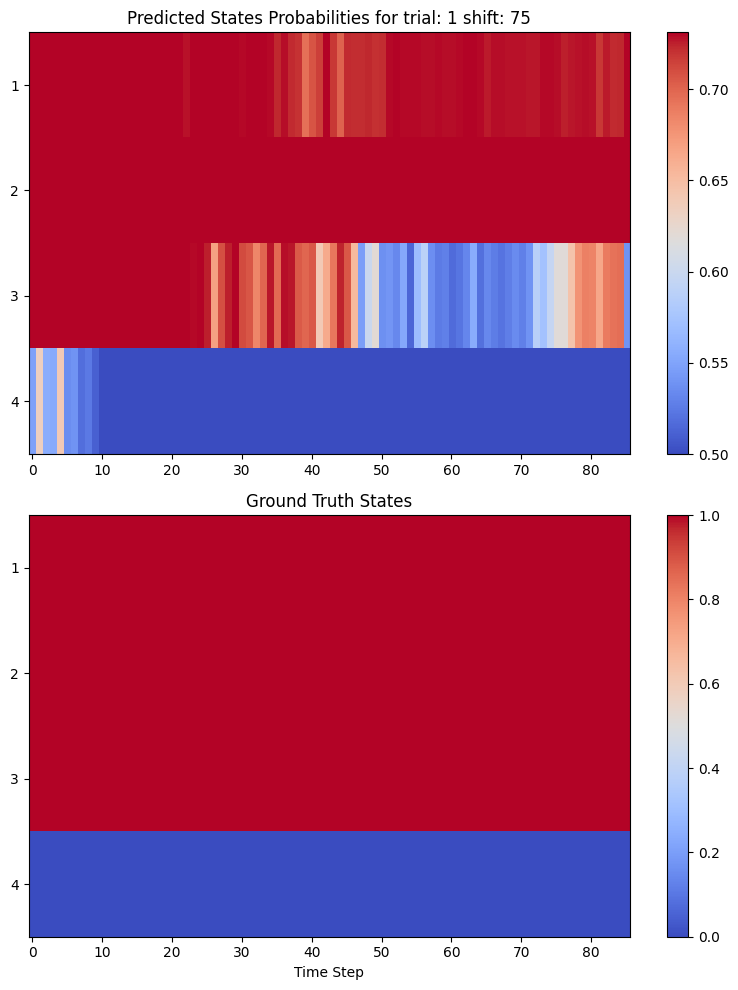

Epoch 0, train loss: 0.7146866917610168, train acc: 0.5250823164826651
Epoch 10, train loss: 0.4487549066543579, train acc: 0.8142068564787914
Epoch 20, train loss: 0.36085307598114014, train acc: 0.8538156110788301
Epoch 30, train loss: 0.29026588797569275, train acc: 0.8861127251597908
Epoch 40, train loss: 0.23896467685699463, train acc: 0.90746658919233
Epoch 50, train loss: 0.2016936093568802, train acc: 0.924414100329266
Epoch 60, train loss: 0.17370276153087616, train acc: 0.9371973658725548
Epoch 70, train loss: 0.15457260608673096, train acc: 0.9439763703273291
Epoch 80, train loss: 0.13441865146160126, train acc: 0.9525953902769707
Epoch 90, train loss: 0.12070946395397186, train acc: 0.9593259732713538
Epoch 100, train loss: 0.10890668630599976, train acc: 0.9633933759442185
Epoch 110, train loss: 0.09761324524879456, train acc: 0.9674607786170831
Epoch 120, train loss: 0.08796461671590805, train acc: 0.9715281812899477
Epoch 130, train loss: 0.08150287717580795, train acc: 

<Figure size 640x480 with 0 Axes>

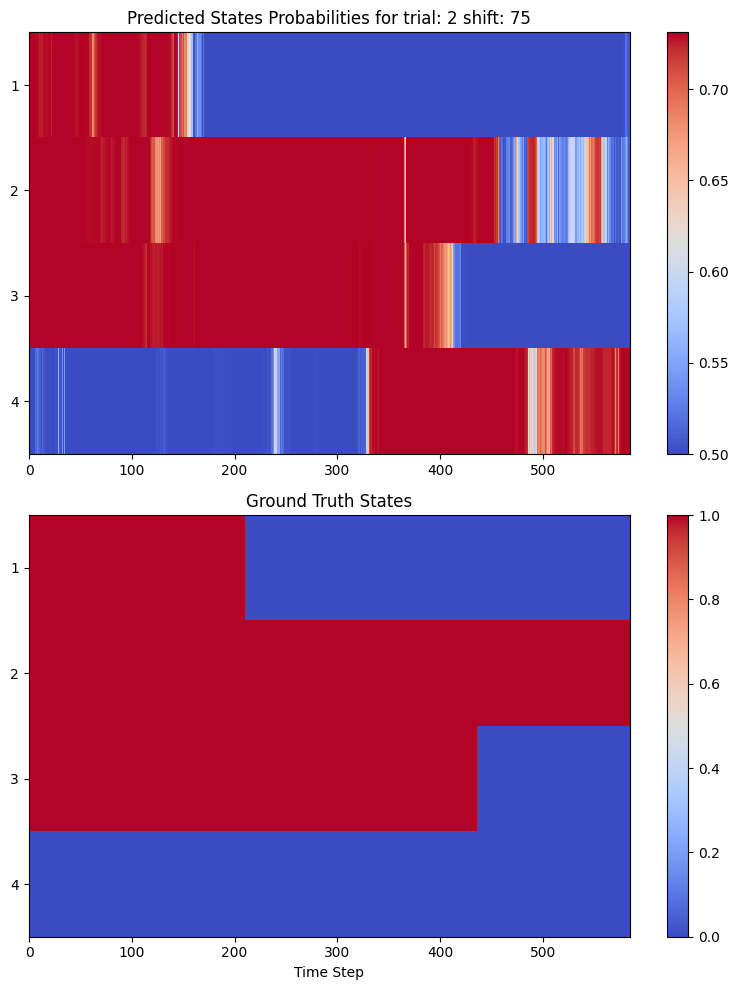

Epoch 0, train loss: 0.7235142588615417, train acc: 0.5295180722891566
Epoch 10, train loss: 0.45597270131111145, train acc: 0.8068118628359592
Epoch 20, train loss: 0.3721388578414917, train acc: 0.8517145505097312
Epoch 30, train loss: 0.298825204372406, train acc: 0.8917516218721038
Epoch 40, train loss: 0.2378407120704651, train acc: 0.9177479147358666
Epoch 50, train loss: 0.19603894650936127, train acc: 0.9304448563484709
Epoch 60, train loss: 0.1702478677034378, train acc: 0.9379518072289157
Epoch 70, train loss: 0.14642752707004547, train acc: 0.9480074142724745
Epoch 80, train loss: 0.13029615581035614, train acc: 0.9549582947173308
Epoch 90, train loss: 0.11173689365386963, train acc: 0.9636237256719185
Epoch 100, train loss: 0.09879422932863235, train acc: 0.9674698795180723
Epoch 110, train loss: 0.09470458328723907, train acc: 0.9685356811862836
Epoch 120, train loss: 0.08083838224411011, train acc: 0.9737720111214088
Epoch 130, train loss: 0.07262269407510757, train acc: 

<Figure size 640x480 with 0 Axes>

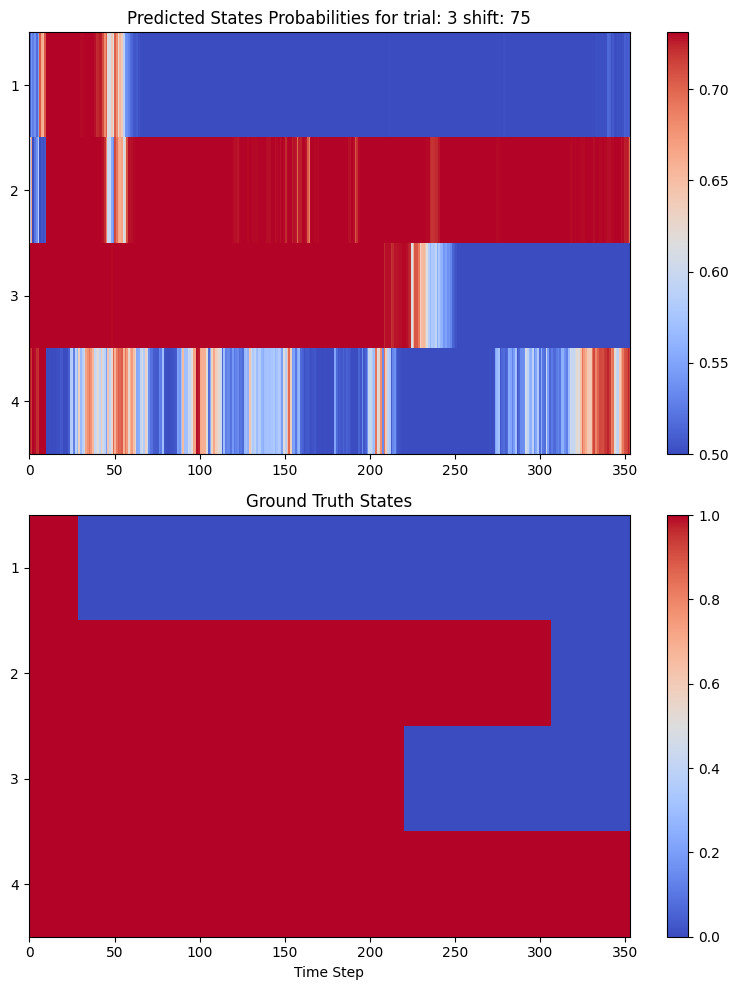

Epoch 0, train loss: 0.8189567923545837, train acc: 0.40923448532144185
Epoch 10, train loss: 0.4791593551635742, train acc: 0.7834448160535117
Epoch 20, train loss: 0.40256181359291077, train acc: 0.8431345224823485
Epoch 30, train loss: 0.3340611159801483, train acc: 0.8696581196581197
Epoch 40, train loss: 0.2797684669494629, train acc: 0.8907004830917874
Epoch 50, train loss: 0.24080868065357208, train acc: 0.8979468599033816
Epoch 60, train loss: 0.21201921999454498, train acc: 0.9141118543292457
Epoch 70, train loss: 0.18754427134990692, train acc: 0.9295336306205871
Epoch 80, train loss: 0.16680796444416046, train acc: 0.9388238573021181
Epoch 90, train loss: 0.15027345716953278, train acc: 0.9482998885172799
Epoch 100, train loss: 0.13571302592754364, train acc: 0.9541527313266444
Epoch 110, train loss: 0.1211697906255722, train acc: 0.9606094388703085
Epoch 120, train loss: 0.10869920998811722, train acc: 0.966044221479004
Epoch 130, train loss: 0.10275068879127502, train acc:

<Figure size 640x480 with 0 Axes>

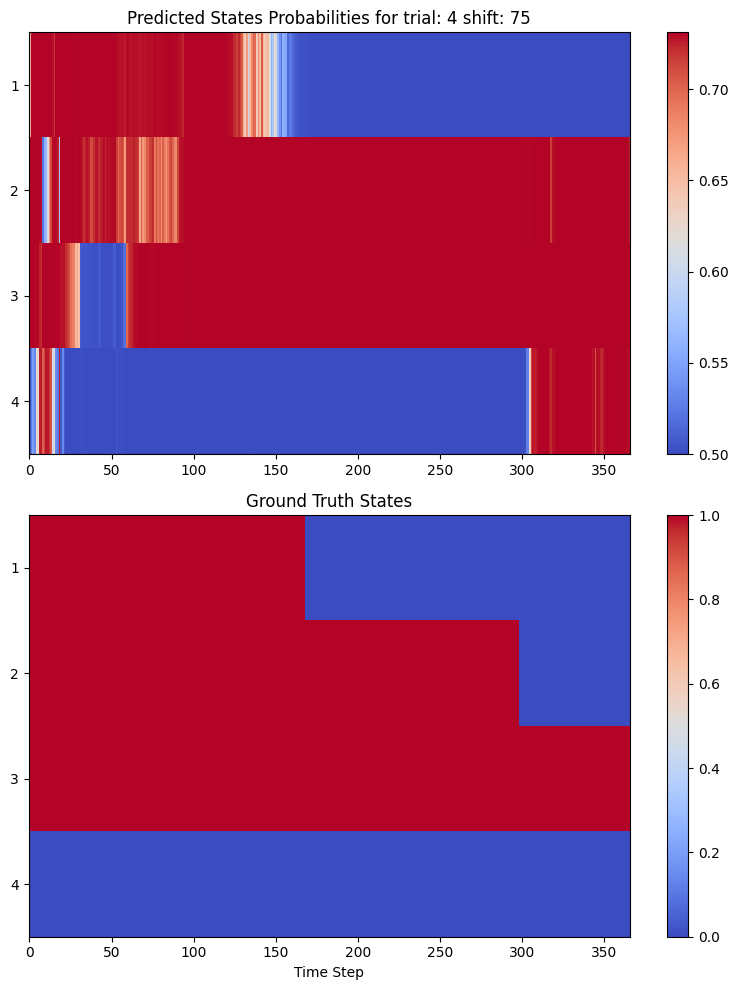

Epoch 0, train loss: 0.7218732237815857, train acc: 0.4949105783866058
Epoch 10, train loss: 0.4459739029407501, train acc: 0.8074105783866058
Epoch 20, train loss: 0.36559000611305237, train acc: 0.8467941400304414
Epoch 30, train loss: 0.2998136579990387, train acc: 0.8795662100456622
Epoch 40, train loss: 0.2523285448551178, train acc: 0.896023592085236
Epoch 50, train loss: 0.2183324545621872, train acc: 0.9087233637747336
Epoch 60, train loss: 0.1951158046722412, train acc: 0.9215658295281582
Epoch 70, train loss: 0.1747065931558609, train acc: 0.9278443683409436
Epoch 80, train loss: 0.15681736171245575, train acc: 0.939259893455099
Epoch 90, train loss: 0.1413525938987732, train acc: 0.9473934550989346
Epoch 100, train loss: 0.1283980756998062, train acc: 0.9532439117199392
Epoch 110, train loss: 0.1148083284497261, train acc: 0.9595700152207002
Epoch 120, train loss: 0.10409089177846909, train acc: 0.963755707762557
Epoch 130, train loss: 0.09661929309368134, train acc: 0.96708

<Figure size 640x480 with 0 Axes>

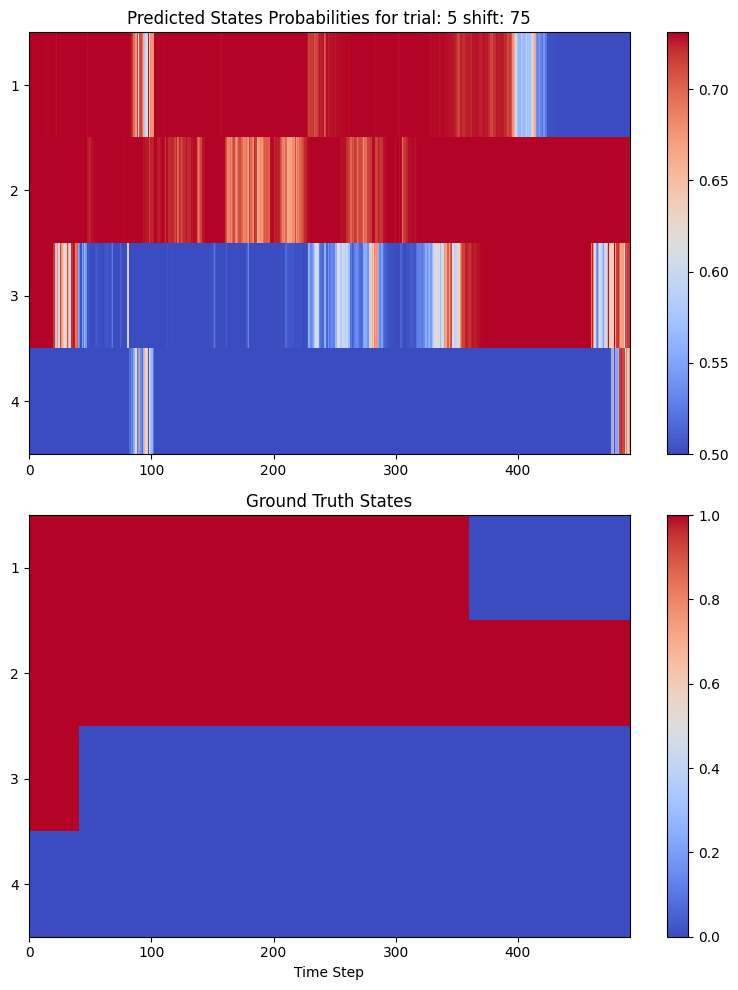

Epoch 0, train loss: 0.6904775500297546, train acc: 0.5328351012536162
Epoch 10, train loss: 0.45757099986076355, train acc: 0.8112343297974928
Epoch 20, train loss: 0.374247282743454, train acc: 0.8454194792671167
Epoch 30, train loss: 0.3004733622074127, train acc: 0.8853423336547734
Epoch 40, train loss: 0.23985745012760162, train acc: 0.9042430086788814
Epoch 50, train loss: 0.19795513153076172, train acc: 0.918900675024108
Epoch 60, train loss: 0.16877716779708862, train acc: 0.9311957569913211
Epoch 70, train loss: 0.14433841407299042, train acc: 0.9445515911282546
Epoch 80, train loss: 0.12359695881605148, train acc: 0.9532786885245902
Epoch 90, train loss: 0.10735239088535309, train acc: 0.9617164898746384
Epoch 100, train loss: 0.09705087542533875, train acc: 0.9668756027000964
Epoch 110, train loss: 0.0848955512046814, train acc: 0.9704918032786886
Epoch 120, train loss: 0.07509997487068176, train acc: 0.9764223722275795
Epoch 130, train loss: 0.06969050318002701, train acc: 

<Figure size 640x480 with 0 Axes>

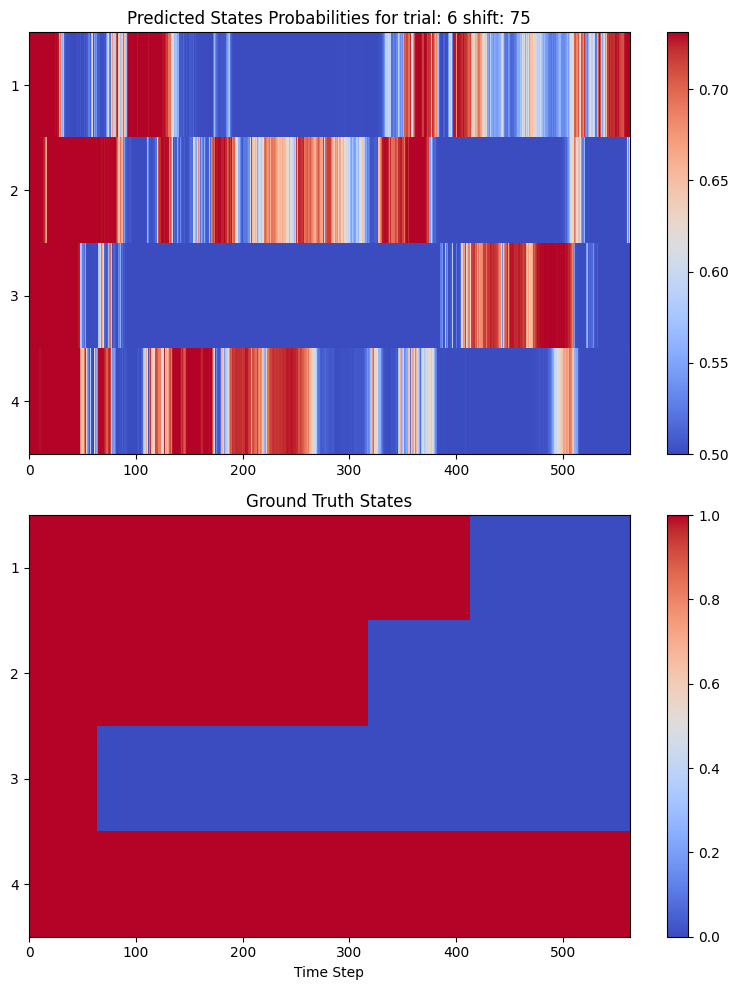

Epoch 0, train loss: 0.7745537757873535, train acc: 0.4622851072049449
Epoch 10, train loss: 0.4694271385669708, train acc: 0.7731311570407572
Epoch 20, train loss: 0.39223864674568176, train acc: 0.8235947459918872
Epoch 30, train loss: 0.3243080675601959, train acc: 0.8609233146610006
Epoch 40, train loss: 0.27088722586631775, train acc: 0.884006181186015
Epoch 50, train loss: 0.23471152782440186, train acc: 0.9002800849913077
Epoch 60, train loss: 0.2068837434053421, train acc: 0.9158779215762024
Epoch 70, train loss: 0.18225817382335663, train acc: 0.9286749082480201
Epoch 80, train loss: 0.16241852939128876, train acc: 0.9383330113965617
Epoch 90, train loss: 0.144300177693367, train acc: 0.9484257291867877
Epoch 100, train loss: 0.12813329696655273, train acc: 0.9550415298435387
Epoch 110, train loss: 0.11474218219518661, train acc: 0.9612227158586054
Epoch 120, train loss: 0.10324826836585999, train acc: 0.9654239907282209
Epoch 130, train loss: 0.09377722442150116, train acc: 0

<Figure size 640x480 with 0 Axes>

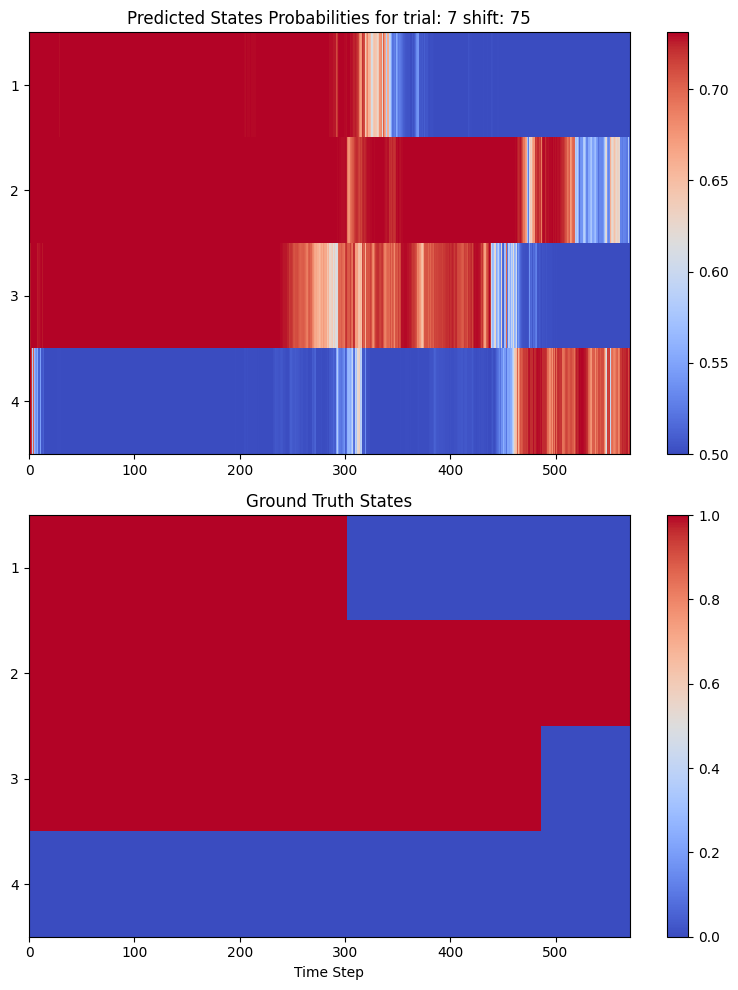

Epoch 0, train loss: 0.6194796562194824, train acc: 0.620610406324692
Epoch 10, train loss: 0.41753455996513367, train acc: 0.8410553410553411
Epoch 20, train loss: 0.3357846140861511, train acc: 0.873138444567016
Epoch 30, train loss: 0.2675327956676483, train acc: 0.8987405773120059
Epoch 40, train loss: 0.21637101471424103, train acc: 0.915425629711344
Epoch 50, train loss: 0.18162144720554352, train acc: 0.9273303916161059
Epoch 60, train loss: 0.15801851451396942, train acc: 0.9373046515903659
Epoch 70, train loss: 0.13752929866313934, train acc: 0.9505883434454863
Epoch 80, train loss: 0.12211143225431442, train acc: 0.959275602132745
Epoch 90, train loss: 0.1070958748459816, train acc: 0.9678249678249679
Epoch 100, train loss: 0.09603188931941986, train acc: 0.9703070417356132
Epoch 110, train loss: 0.0864005759358406, train acc: 0.9736624379481522
Epoch 120, train loss: 0.07788649201393127, train acc: 0.9766501195072623
Epoch 130, train loss: 0.07306526601314545, train acc: 0.9

<Figure size 640x480 with 0 Axes>

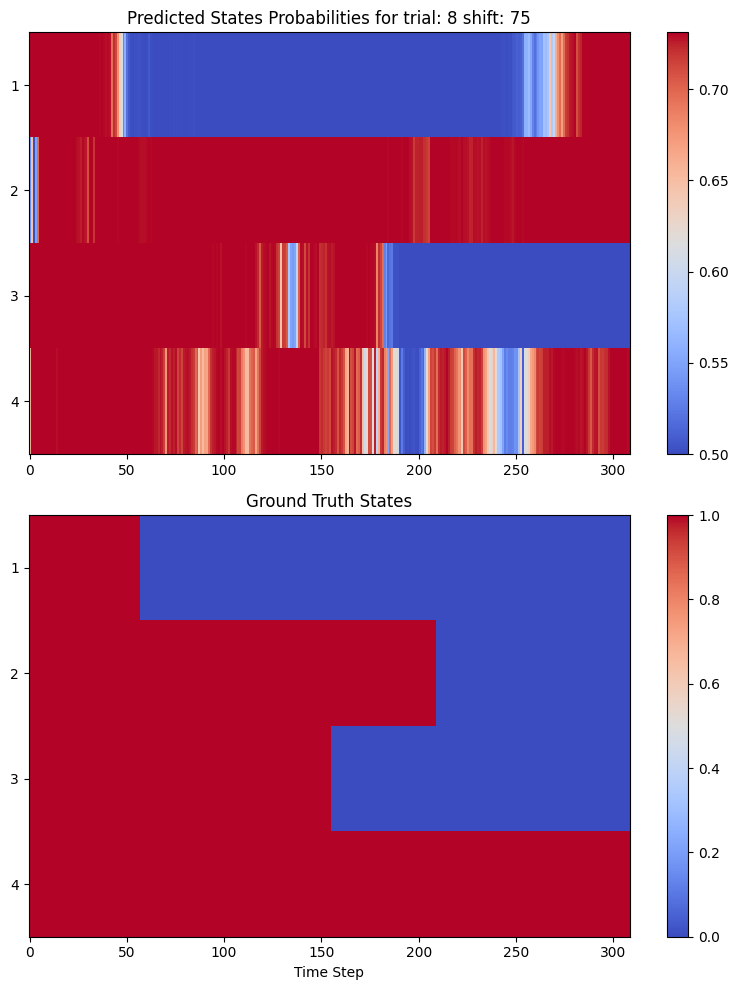

Epoch 0, train loss: 0.7692107558250427, train acc: 0.39846743295019155
Epoch 10, train loss: 0.4713059365749359, train acc: 0.7872126436781609
Epoch 20, train loss: 0.3835696578025818, train acc: 0.8533524904214559
Epoch 30, train loss: 0.31303733587265015, train acc: 0.8901340996168582
Epoch 40, train loss: 0.25739043951034546, train acc: 0.9074233716475095
Epoch 50, train loss: 0.21983923017978668, train acc: 0.9136973180076629
Epoch 60, train loss: 0.19268810749053955, train acc: 0.9270114942528735
Epoch 70, train loss: 0.16952699422836304, train acc: 0.9369731800766283
Epoch 80, train loss: 0.1493660807609558, train acc: 0.946168582375479
Epoch 90, train loss: 0.13256105780601501, train acc: 0.9551245210727969
Epoch 100, train loss: 0.11671799421310425, train acc: 0.9614463601532567
Epoch 110, train loss: 0.10439977794885635, train acc: 0.9648946360153257
Epoch 120, train loss: 0.09537898749113083, train acc: 0.9677681992337165
Epoch 130, train loss: 0.08597438782453537, train acc

<Figure size 640x480 with 0 Axes>

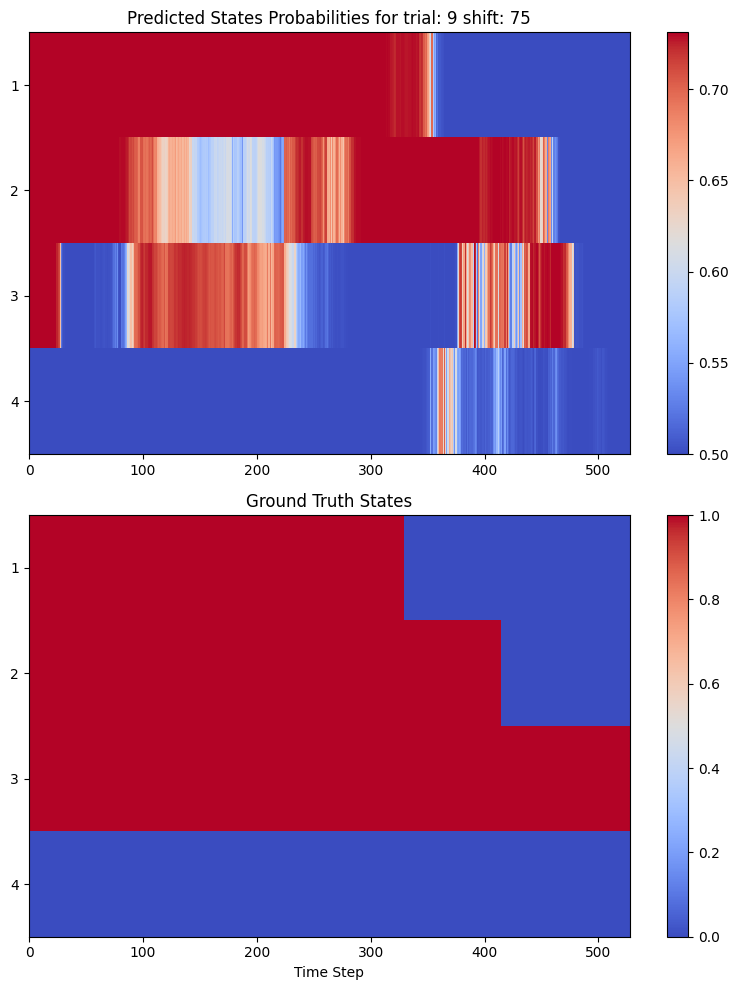

Epoch 0, train loss: 0.7164940237998962, train acc: 0.49018717063419953
Epoch 10, train loss: 0.44848594069480896, train acc: 0.8071052153370889
Epoch 20, train loss: 0.3699261546134949, train acc: 0.8471742685807742
Epoch 30, train loss: 0.3048335611820221, train acc: 0.8799745593312739
Epoch 40, train loss: 0.25166431069374084, train acc: 0.8986461929856442
Epoch 50, train loss: 0.2147531807422638, train acc: 0.9141377430492459
Epoch 60, train loss: 0.18705111742019653, train acc: 0.9262220606941668
Epoch 70, train loss: 0.16645748913288116, train acc: 0.9374886425586044
Epoch 80, train loss: 0.15004447102546692, train acc: 0.9453934217699437
Epoch 90, train loss: 0.1333208829164505, train acc: 0.9538433581682718
Epoch 100, train loss: 0.12056703865528107, train acc: 0.9597492276939851
Epoch 110, train loss: 0.10810349136590958, train acc: 0.963292749409413
Epoch 120, train loss: 0.09821289777755737, train acc: 0.9667454115936762
Epoch 130, train loss: 0.09362158179283142, train acc:

<Figure size 640x480 with 0 Axes>

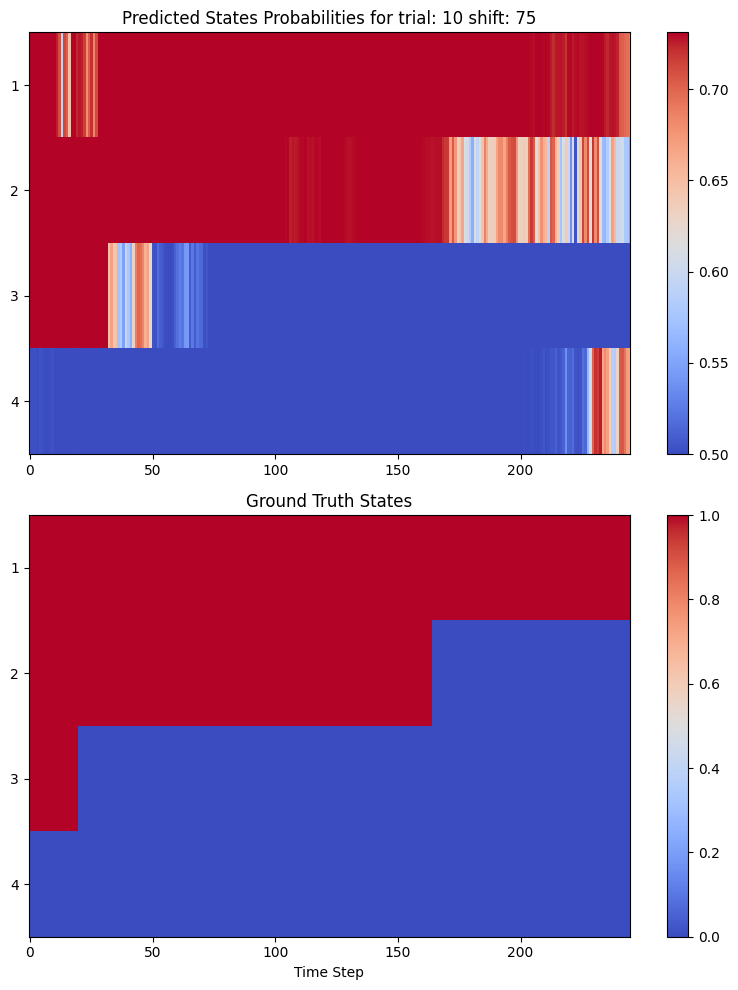

Epoch 0, train loss: 0.6805635690689087, train acc: 0.5850230414746543
Epoch 10, train loss: 0.4436546266078949, train acc: 0.8028571428571428
Epoch 20, train loss: 0.3628913462162018, train acc: 0.8468663594470046
Epoch 30, train loss: 0.29835042357444763, train acc: 0.8828571428571429
Epoch 40, train loss: 0.24949081242084503, train acc: 0.896036866359447
Epoch 50, train loss: 0.21413427591323853, train acc: 0.9141013824884793
Epoch 60, train loss: 0.18870465457439423, train acc: 0.9226728110599078
Epoch 70, train loss: 0.16617335379123688, train acc: 0.9345161290322581
Epoch 80, train loss: 0.1474534273147583, train acc: 0.9455299539170506
Epoch 90, train loss: 0.12946228682994843, train acc: 0.9529493087557603
Epoch 100, train loss: 0.11430095881223679, train acc: 0.9622119815668203
Epoch 110, train loss: 0.1062672808766365, train acc: 0.9631336405529954
Epoch 120, train loss: 0.09486756473779678, train acc: 0.9672811059907834
Epoch 130, train loss: 0.08633008599281311, train acc: 

<Figure size 640x480 with 0 Axes>

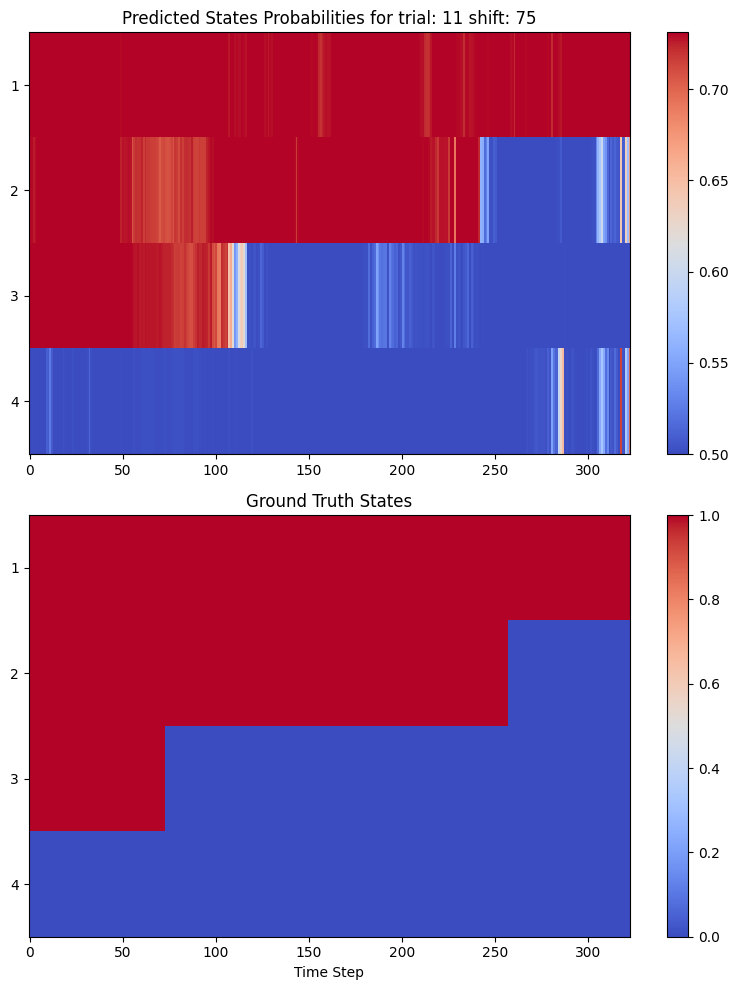

Epoch 0, train loss: 0.7183489799499512, train acc: 0.5397405444911383
Epoch 10, train loss: 0.45654118061065674, train acc: 0.8034441805225653
Epoch 20, train loss: 0.3778391182422638, train acc: 0.8395304220719898
Epoch 30, train loss: 0.3083634078502655, train acc: 0.8747030878859857
Epoch 40, train loss: 0.25008514523506165, train acc: 0.9114745112369815
Epoch 50, train loss: 0.20923273265361786, train acc: 0.9197423716426092
Epoch 60, train loss: 0.1790074110031128, train acc: 0.931162068335465
Epoch 70, train loss: 0.15715326368808746, train acc: 0.9415768317193496
Epoch 80, train loss: 0.13863427937030792, train acc: 0.9493422254704915
Epoch 90, train loss: 0.12189362943172455, train acc: 0.9583409464644619
Epoch 100, train loss: 0.10953240841627121, train acc: 0.9635483281564041
Epoch 110, train loss: 0.10116423666477203, train acc: 0.9669742371642609
Epoch 120, train loss: 0.09189484268426895, train acc: 0.9694865704366892
Epoch 130, train loss: 0.08419851958751678, train acc:

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [133]:
# Hyperparameters
input_dim = 60
output_dim = 4
num_layers = 1


columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']

df_human = pd.read_csv("data_human_jarvis.csv")
df_human = df_human.drop(columns=['H_id','s_1','s_2','s_3','s_4'])
file = "data_model_v3.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)

labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial','H_trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['id','trial','s_1','s_2','s_3','s_4']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift



probs_dict_smh = {}
hidden_states_dict = {}
test_predictions_dict_smh = {}
test_probs_dict_smh = {}
train_probs_dict_smh = {}
train_predictions_dict_smh = {}
train_accs_all = []
test_accs_all = []

for n in np.arange(300,451,step=150):
    for l in [0.005,0.001]:
        for j in np.arange(1,16):    
            shift = 75
            set_values = j
            k = set_values - 1
            num_layers = 1
            hidden_dim = 38
            n_epochs = n 
            lr = l
            model_name = 's_m_h_'+str(set_values)+"_"+str(n_epochs)+"_"+str(hidden_dim)+"_"+str(num_layers)+"_"+str(lr)+"_"
            # Create an instance of GRUCellNet
            model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

            # Define loss function and optimizer
            class_weights = torch.tensor([1.8]).to(device)
            loss_fn = nn.BCELoss()  
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)


            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in scaled_df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + '_minus_' + str(shift)
                    trial_df[new_col_name] = trial_df[col].shift(shift)

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()

                # Append the modified trial_df to the shifted_df
                shifted_df = shifted_df.append(trial_df, ignore_index=True)
            

            selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
            'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
            'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
            'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
            'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
            'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
            'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
            'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
            'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
            'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
            'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
            'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
            'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
            'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
            'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
            'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
        'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
            shifted_df = shifted_df[selected_columns]
            # Step 5: Split the data into training and test sets based on the 'trial' column
            # Step 5: Split the data into training and test sets based on the 'trial' column
            train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
            test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
            full_set = shifted_df.drop(columns=['id','trial'])

            # split data into x and y 
            X_train, y_train = train_set.drop(columns=labels), train_set[labels]
            X_test, y_test = test_set.drop(columns=labels), test_set[labels]
            X, y = full_set.drop(columns=labels), full_set[labels]
            
            # reset index 
            X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
            X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
            X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

            # Create custom datasets for training, validation, and testing
            full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
            train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
            test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

            fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
            train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
            test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


            train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
                train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
            
                        # Specify the folder path and the model filename
            folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_hypertuning/' 
            model_filename = model_name + '.pth'  

            # Combine the folder path and model filename
            full_model = os.path.join(folder_path, model_filename)

            # Save the model to the specified folder
            torch.save(state_dict, full_model)
            
            model.eval()  # Set the model to evaluation mode
            # Initialize an empty list to store predictions
            test_preds = []
            test_probs = []
            train_probs = []
            train_preds = []
            
            # Iterate through the test data batches
            for inputs, _ in test_dataloader:
                inputs = inputs.float()
                # Forward pass to get predictions
                with torch.no_grad():
                    predictions, f,f = model(inputs)
                    probabilities = torch.sigmoid(predictions)
                    preds = torch.round(probabilities)

                # Append predictions to the list
                test_preds.append(preds)
                test_probs.append(probabilities)

            # Concatenate the predicted batches
            test_preds = torch.cat(test_preds, dim=0)
            test_probs = torch.cat(test_probs, dim=0)

            test_preds_array = test_preds.numpy()
            test_probs_array = test_probs.numpy()
            
            # Iterate through the test data batches
            for inputs, _ in train_dataloader:
                inputs = inputs.float()
                # Forward pass to get predictions
                with torch.no_grad():
                    predictions, f,f = model(inputs)
                    probabilities = torch.sigmoid(predictions)
                    preds = torch.round(probabilities)

                # Append predictions to the list
                train_preds.append(preds)
                train_probs.append(probabilities)

            # Concatenate the predicted batches
            train_preds = torch.cat(train_preds, dim=0)
            train_probs = torch.cat(train_probs, dim=0)

            train_preds_array = train_preds.numpy()
            train_probs_array = train_probs.numpy()

            columns = ['s_1','s_2','s_3','s_4']
            test_probs_df = pd.DataFrame(test_probs_array)
            train_probs_df = pd.DataFrame(train_probs_array)
            train_probs_df.columns = columns
            test_probs_df.columns = columns 
            # Convert the tensor of predictions to a DataFrame
            test_preds_df = pd.DataFrame(test_preds_array, columns=y_test.columns, index=y_test.index)
            train_preds_df = pd.DataFrame(train_preds_array, columns=y_train.columns, index=y_train.index)
            # Calculate accuracy for each output state
            test_accuracies = (test_preds_df == y_test).mean()
            train_accuracies = (train_preds_df == y_train).mean()
            # Construct the key for the combination
            key = f"smh_shift{shift}_set{set_values}"

            # Store the predictions as NumPy arrays in the dictionary
            test_predictions_dict_smh[key] = test_preds_array 
            test_probs_dict_smh[key] = test_probs_array 
            
            train_predictions_dict_smh[key] = train_preds_array
            train_probs_dict_smh[key] = train_probs_array
            
            print(model_name)
            print("Accuracy for each output state in",model_name)
            print(np.mean(test_accuracies))
            test_accs = np.mean(test_accuracies)
            train_accs = np.mean(train_accuracies)
            
            test_accs_all.append(test_accs)
            train_accs_all.append(train_accs)
            
            #spec = specificity(y_test.values, test_preds_df.values)
            print(spec)
            file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/predictions/test/" + str(model_name) + "_test_probs.csv"
            np.savetxt(file_path, test_probs_array, delimiter=',')
            file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/predictions/test/" + str(model_name) + "_train_probs.csv"
            np.savetxt(file_path,train_probs_array,delimiter=',')
            
            
                # Specify the name of the folder you want to create
            
            folder_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/hyperparameter_tuning/"
            
            
            file_name = 'results_hyperparameter_tuning_smh.txt'
            file_path = folder_path + file_name  # Replace with your desired file path
            value_to_save = model_name+"_"+str(test_accs)  # Replace with the value you want to save

            try:
                with open(file_path, "a") as file:
                    # 2. Write the value to the file
                    file.write(value_to_save)
                    print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
            except Exception as e:
                print(f"An error occurred: {e}")
                
            keys_list = list(test_probs_dict_smh.keys())
            trial_key = keys_list[k]
            y_hat = test_probs_dict_smh[trial_key]
            y_labels = ['1', '2', '3', '4']

            # Create a figure with a grid of subplots (2 rows, 1 column)
            fig, axs = plt.subplots(2,1, figsize=(8,10))

            # Create the first heatmap plot in the first subplot
            heatmap1 = axs[0].imshow(test_probs_array.T, cmap='coolwarm', aspect='auto', interpolation='none')

            # Add colorbar to the first heatmap subplot
            cbar1 = plt.colorbar(heatmap1, ax=axs[0])
            # Set the axis labels and title for the first heatmap subplot
            #axs[0].set_xlabel('Time Step')
            #axs[0].set_ylabel('Predicted State')
            axs[0].set_title('Predicted States Probabilities for trial: '+ str(set_values) + " " + "shift: " + str(shift))

            # Set the y-axis ticks and labels for the first heatmap subplot
            axs[0].set_yticks(np.arange(len(y_labels)))
            axs[0].set_yticklabels(y_labels)





            # Set the axis labels and title for the second heatmap subplot
            axs[1].set_xlabel('Time Step')
            #axs[1].set_ylabel('Predicted State')
            axs[1].set_title('Ground Truth States')
                # Create the second heatmap plot in the second subplot
            heatmap2 = axs[1].imshow(y_test.T, cmap='coolwarm', aspect='auto', interpolation='none')
            # Add colorbar to the second heatmap subplot
            cbar2 = plt.colorbar(heatmap2, ax=axs[1])
            # Set the y-axis ticks and labels for the second heatmap subplot
            axs[1].set_yticks(np.arange(len(y_labels)))
            axs[1].set_yticklabels(y_labels)

            # Adjust spacing between subplots
            plt.tight_layout()

            # Show the plots
            plot_name = str(model_name)+'_heatmap_v3.jpg'
            plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/new_heatmaps/'+plot_name)

            plt.show()
            plt.clf()
            
            
        plt.figure(figsize=(8, 8))
        scatter_plot = plt.scatter(test_accs_all, train_accs_all)
        plt.xlabel('Test Accuracy')
        plt.ylabel('Train Accuracy')
        #plt.axis('equal')
        plt.title("Accuracies for shift=75")
        plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9])
        plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])
        plt.plot([0.5, 0.9], [0.5, 0.9], linestyle='--', color='gray')
        plt.show()
        plot_name = str(model_name)+'_accuracy.jpg'
        plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/new_heatmaps/'+plot_name)
        plt.show()
        plt.clf()   
    
            
            
        

In [ ]:
plt.figure(figsize=(8, 8))
scatter_plot = plt.scatter(test_accs_all, train_accs_all)
plt.xlabel('Test Accuracy')
plt.ylabel('Train Accuracy')
#plt.axis('equal')
plt.title("Accuracies for shift=75")
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.plot([0.5, 0.9], [0.5, 0.9], linestyle='--', color='gray')
plt.show()

In [ ]:
for k in np.arange(0,15):
    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()
    shift = 75
    set_values = k + 1 

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)
    

    selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
    'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
    'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
    'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
    'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
    'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
    'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
    'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
    'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
    'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
    'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
    'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
    'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
    'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
    'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
    'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift),'s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift)]
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X, y = full_set.drop(columns=labels), full_set[labels]
    
    # reset index 
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    X, y = X.reset_index(drop=True), y.reset_index(drop=True) 
    keys_list = list(test_probs_dict_smh.keys())
    trial_key = keys_list[k]
    y_hat = test_probs_dict_smh[trial_key]
    y_labels = ['1', '2', '3', '4']

    # Create a figure with a grid of subplots (2 rows, 1 column)
    fig, axs = plt.subplots(2,1, figsize=(8,10))

    # Create the first heatmap plot in the first subplot
    heatmap1 = axs[0].imshow(test_probs_array.T, cmap='coolwarm', aspect='auto', interpolation='none')

    # Add colorbar to the first heatmap subplot
    cbar1 = plt.colorbar(heatmap1, ax=axs[0])
    # Set the axis labels and title for the first heatmap subplot
    #axs[0].set_xlabel('Time Step')
    #axs[0].set_ylabel('Predicted State')
    axs[0].set_title('Predicted States Probabilities for trial: '+ str(set_values) + " " + "shift: " + str(shift))

    # Set the y-axis ticks and labels for the first heatmap subplot
    axs[0].set_yticks(np.arange(len(y_labels)))
    axs[0].set_yticklabels(y_labels)





    # Set the axis labels and title for the second heatmap subplot
    axs[1].set_xlabel('Time Step')
    #axs[1].set_ylabel('Predicted State')
    axs[1].set_title('Ground Truth States')
        # Create the second heatmap plot in the second subplot
    heatmap2 = axs[1].imshow(y_test.T, cmap='coolwarm', aspect='auto', interpolation='none')
    # Add colorbar to the second heatmap subplot
    cbar2 = plt.colorbar(heatmap2, ax=axs[1])
    # Set the y-axis ticks and labels for the second heatmap subplot
    axs[1].set_yticks(np.arange(len(y_labels)))
    axs[1].set_yticklabels(y_labels)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plot_name = 'trial'+str(set_values)+'_'+'shift'+str(shift)+'_heatmap_v3.jpg'
    plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/new_heatmaps/'+plot_name)

    plt.show()

In [ ]:
keys_list = list(test_probs_dict_smh.keys())
trial_key = keys_list[k]
y_hat = test_probs_dict_smh[trial_key]

In [ ]:
test_probs_dict_smh.keys()

In [ ]:
keys_list

In [ ]:
shifted_df = pd.DataFrame()
shift = 75
set_values = 15
num_epochs = 300
hidden_dim = 50 

# Loop through unique trial values
for trial_value in scaled_df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + '_minus_' + str(shift)
        trial_df[new_col_name] = trial_df[col].shift(shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = shifted_df.append(trial_df, ignore_index=True)


selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift),'s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift)]
shifted_df = shifted_df[selected_columns]
# Step 5: Split the data into training and test sets based on the 'trial' column
# Step 5: Split the data into training and test sets based on the 'trial' column
train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
full_set = shifted_df.drop(columns=['id','trial'])

# split data into x and y 
X_train, y_train = train_set.drop(columns=labels), train_set[labels]
X_test, y_test = test_set.drop(columns=labels), test_set[labels]
X, y = full_set.drop(columns=labels), full_set[labels]

# reset index 
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
X, y = X.reset_index(drop=True), y.reset_index(drop=True) 
keys_list = list(test_probs_dict_smh.keys())
trial_key = keys_list[k]
y_hat = test_probs_dict_smh[trial_key]
y_labels = ['1', '2', '3', '4']

# Create a figure with a grid of subplots (2 rows, 1 column)
fig, axs = plt.subplots(2,1, figsize=(8,10))

# Create the first heatmap plot in the first subplot
heatmap1 = axs[0].imshow(test_probs_array.T, cmap='coolwarm', aspect='auto', interpolation='none')

# Add colorbar to the first heatmap subplot
cbar1 = plt.colorbar(heatmap1, ax=axs[0])
# Set the axis labels and title for the first heatmap subplot
#axs[0].set_xlabel('Time Step')
#axs[0].set_ylabel('Predicted State')
axs[0].set_title('Predicted States Probabilities for trial: '+ str(set_values) + " " + "shift: " + str(shift)+" hidden dim: "+str(hidden_dim)+" num epochs: "+str(num_epochs))

# Set the y-axis ticks and labels for the first heatmap subplot
axs[0].set_yticks(np.arange(len(y_labels)))
axs[0].set_yticklabels(y_labels)





# Set the axis labels and title for the second heatmap subplot
axs[1].set_xlabel('Time Step')
#axs[1].set_ylabel('Predicted State')
axs[1].set_title('Ground Truth States')
    # Create the second heatmap plot in the second subplot
heatmap2 = axs[1].imshow(y_test.T, cmap='coolwarm', aspect='auto', interpolation='none')
# Add colorbar to the second heatmap subplot
cbar2 = plt.colorbar(heatmap2, ax=axs[1])
# Set the y-axis ticks and labels for the second heatmap subplot
axs[1].set_yticks(np.arange(len(y_labels)))
axs[1].set_yticklabels(y_labels)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plot_name = 'trial'+str(set_values)+'_'+'shift'+str(shift)+'_heatmap.jpg'
plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/new_heatmaps/'+plot_name)

plt.show()

In [ ]:
test_accs_all

In [ ]:
probs_dict_smh.keys()

In [ ]:
for i in np.arange(1,16):
    shift = 75
    set_values = i 
    k = i - 1  


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
    # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + '_minus_' + str(shift)
        trial_df[new_col_name] = trial_df[col].shift(shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = shifted_df.append(trial_df, ignore_index=True)


    selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
    'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
    'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
    'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
    'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
    'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
    'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
    'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
    'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
    'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
    'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
    'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
    'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
    'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
    'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
    'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
    'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift),'s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift)]
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X, y = full_set.drop(columns=labels), full_set[labels]

    # reset index 
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

    keys_list = list(probs_dict_smh.keys())
    trial_key = keys_list[k]
    y_hat = probs_dict_smh[trial_key]

    actual_values = y_test
    # Define the labels for the y-axis (predicted states)
    y_labels = ['1', '2', '3', '4']

    # Create a figure with a grid of subplots (2 rows, 1 column)
    fig, axs = plt.subplots(2,1, figsize=(8,10))

    # Create the first heatmap plot in the first subplot
    heatmap1 = axs[0].imshow(all_probs_array.T, cmap='coolwarm', aspect='auto', interpolation='none')

    # Add colorbar to the first heatmap subplot
    cbar1 = plt.colorbar(heatmap1, ax=axs[0])
    # Set the axis labels and title for the first heatmap subplot
    #axs[0].set_xlabel('Time Step')
    #axs[0].set_ylabel('Predicted State')
    axs[0].set_title('Predicted States Probabilities for trial: '+ str(set_values) + " " + "shift: " + str(shift))

    # Set the y-axis ticks and labels for the first heatmap subplot
    axs[0].set_yticks(np.arange(len(y_labels)))
    axs[0].set_yticklabels(y_labels)



    # Add colorbar to the second heatmap subplot
    cbar2 = plt.colorbar(heatmap2, ax=axs[1])
    print(y_test)
    # Set the axis labels and title for the second heatmap subplot
    axs[1].set_xlabel('Time Step')
    #axs[1].set_ylabel('Predicted State')
    axs[1].set_title('Ground Truth States')
        # Create the second heatmap plot in the second subplot
    heatmap2 = axs[1].imshow(actual_values.T, cmap='coolwarm', aspect='auto', interpolation='none')
    # Set the y-axis ticks and labels for the second heatmap subplot
    axs[1].set_yticks(np.arange(len(y_labels)))
    axs[1].set_yticklabels(y_labels)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plot_name = 'trial'+str(set_values)+'_'+'shift'+str(shift)+'_heatmap.jpg'
    plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/new_heatmaps/'+plot_name)
    
    plt.show()

In [ ]:
keys_list = list(probs_dict_smh.keys())
trial_key = keys_list[k]
y_hat = probs_dict_smh[trial_key]


In [ ]:
values = np.arange(1, 16)
exclude_values = np.array([3, 14])

trials_work = np.setdiff1d(values, exclude_values)
trials_work

In [ ]:
file = "y_tilda_mirror.csv"
y_tilda_org = pd.read_csv(file)
dobre = 0 
input_size = 60

for i in trials_work:
    shift = 75
    set_values = i
    #k = 0+15*(set_values-1)
    k = i - 1
    #print(shift,set_values,k)
    model_name = 'm_h'+str(shift)+'_'+'val'+str(set_values)+'_gates'


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trialk
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)

    #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
    #,s_1_minus_'+str(shift),'s_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['trial','id'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['trial','id'])
    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    #X, y = X.reset_index(drop=True), y.reset_index(drop=True) 
    y_tilda = y_tilda_org[y_tilda_org['trial']==set_values]
    

    y_tilda = y_tilda_org[y_tilda_org['trial']==set_values].drop(columns=['trial','id'])
    col_shift = ['s_1', 's_2', 's_3', 's_4']
    # Loop through unique trial values
        # Create shifted columns for each column in columns_to_shift
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_tilda[new_col_name] = y_tilda[col].shift(shift)

    # Drop the last 'i' records for each trial
    y_tilda = y_tilda.dropna()
    #print(y_tilda.columns)
    y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
    new_column_names = {'s_1_minus_10': 's_1',
                        's_2_minus_10': 's_2',
                        's_3_minus_10': 's_3',
                        's_4_minus_10': 's_4'}

    y_tilda = y_tilda.rename(columns=new_column_names)
    y_tilda = y_tilda.dropna()
    y_tilda = y_tilda.to_numpy()
    
    # Convert the dictionary keys into a list
    keys_list = list(predictions_dict_mh.keys())
    #print(keys_list)
    # Access the second key (index 1 in the list)
    trial_key = keys_list[k]
    y_hat = predictions_dict_mh[trial_key]
    # Assuming you have 'y_hat' and 'y_tilda' as tensors containing binary values (0 or 1)
    y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to PyTorch tensor
    y_hat = y_hat.clone().detach().requires_grad_(True).float()
    #y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
    y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float

    y_hat = y_hat.requires_grad_(True)
    y_tilda = y_tilda.requires_grad_(True)

    # Define the loss function
    #loss_fn = nn.BCELoss()
    # Calculate the loss
    input = torch.tensor(X_test.values)
    input = input.unsqueeze(1)
    input = input.float()
    # set input to require_grad
    input = input.requires_grad_(True)
    model.eval()
    output, f, f = model(input)

    # calculating loss 
    output = output.requires_grad_(True)
    #loss_fn = nn.BCEWithLogitsLoss()
    class_weights = torch.tensor([1.8]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    loss = loss_fn(output,y_tilda) 
    loss.backward()
    #print(input)

    # Access the gradients for the input data
    key = f"sm_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
    input_gradients = input.grad.squeeze(1)

    #print(input_gradients.shape)
    input_gradients_np = input_gradients.numpy()
    dec_line = pd.read_csv('y_tilda_mirror_tag_v2.csv')
    dec_points = dec_line[(dec_line['trial'] == set_values)]
    # Shift all columns by shift
    #dec_points = dec_points.shift(-shift)

    # Drop rows with NaN values
    #dec_points = dec_points.dropna()

    # Reset index
    dec_points = dec_points.reset_index(drop=True)

    # Create DataFrame from NumPy array with the same column names as X_test
    input_gradients = pd.DataFrame(input_gradients_np, columns=X_test.columns)
    #input_gradients = pd.concat([input_gradients, dec_points['id']], axis=1)

    # Reset the index
    input_gradients = input_gradients.reset_index(drop=True)

        # Reset index
    window_size = 10
    #would go with head, wrist (right wrist for monkey, left wrist for human) and neck.
    input_gradients = input_gradients.reset_index(drop=True)
    input_gradients = input_gradients.rolling(window=window_size).mean()
    csv_name = "gradients_"+str(model_name)+"_v2.csv"
    csv_file_path = r"C:\Users\kacpe\Desktop\study\research lab\lab_rotation_git\data_gradients" + "\\" + csv_name
    input_gradients.to_csv(csv_file_path, index=True,float_format='%.10f')
    
    plt.figure(figsize=(15, 6))
    plt.title('gradients for trial: ' + str(set_values) + " " + "shift: " + str(shift))
    plt.plot(input_gradients['rWrist_x_minus_75'],label='monkey right wrist')
    plt.plot(input_gradients['H_headFront_x_minus_75'],label='human head')
    plt.plot(input_gradients['H_leftWrist_x_minus_75'],label='human left wrist')
    plt.plot(input_gradients['neck_x_minus_75'],label='monkey neck')
    plt.plot(input_gradients['headTop_x_minus_75'],label='monkey head')
    
    plt.legend() 

    # Plot the gradients
    for index, row in dec_points[dec_points['tag'] == 1].iterrows():
        plt.axvline(x=row.name, color='r', linestyle='--', label=f'Vertical Line at {row["id"]}', linewidth=1)
    

    # Add any other plotting details or labels as needed
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0e'))
    # Add legend if necessary
    plot_name = 'trial'+str(set_values)+'_'+'shift'+str(shift)+'_gradients.jpg'
    plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/gradients_plots/'+plot_name)
    plt.show()
    

In [ ]:

    # ...

    # Perform an inner join to keep only rows with matching 'id' values in dec_points
    # and input_gradients
    merged_data = pd.merge(input_gradients, dec_points, how='inner', left_index=True, right_index=True)

    print("Number of rows in merged_data after inner join:", len(merged_data))

    # Check for NaN values in common indices
    common_indices_with_nan = merged_data.index[merged_data.isna().any(axis=1)]
    print("Common indices with NaN values in merged_data:")
    print(common_indices_with_nan)

    # Apply moving average smoothing to each column
    merged_data = merged_data.rolling(window=window_size).mean()

    print("Number of rows in merged_data after rolling mean:", len(merged_data))
        
    
    # Apply moving average smoothing to each column
    plt.figure(figsize=(13, 8))
    plt.title('gradients for trial: ' + str(set_values) + " " + "shift: " + str(shift))
    H_neck_x_gradient = merged_data['lShoulder_x_minus_10']
    print(H_neck_x_gradient)
    # Plot the gradients
    plt.plot(H_neck_x_gradient, label='H_neck')
    # Mark points where 'tag' is 1 in dec_points
    for index, row in merged_data[merged_data['tag'] == 1].iterrows():
        plt.axvline(x=index, color='r', linestyle='--', label=f'Vertical Line at {index}')

    plt.legend()
    plt.show()

In [ ]:
    break

    plt.figure(figsize=(13,8))
    plt.title('gradients for trial: '+str(set_values)+" "+"shift: "+str(shift))
    plt.plot(H_lWrist_x_gradient,label='H_leftWrist')
    plt.plot(H_head_x_gradient,label='H_head')
    if (dec_points['tag'] == 1).any():
        plt.axvline(x=dec_points.index[0], color='r', linestyle='--', label='Vertical Line')
   # plt.plot(H_lowerBack_x_gradient,label='H_lowerBack')
    plt.plot(H_neck_x_gradient,label='H_neck')
    print(input_gradients.index)
    print(input_gradients.columns)
    plt.legend()
    

    #for index in dec_points.index:
     #   plt.axvline(x=index, color='red', linestyle='--', label=f'Point {index}')
    
    plot_name = 'trial'+str(set_values)+'_'+'shift'+str(shift)+'_wrist_gradients.jpg'
    plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/gradients_lWrist_rWrist/'+plot_name)

In [ ]:
hidden_states_dict = {}
predictions_dict_mh0 = {}
for j in np.arange(1,16):
    #for i in np.arange(10,151,step=10):
    for i in np.arange(0,1,step=10):    
        shift = i
        set_values = j
        model_name = 'm_h'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
      
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


        train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
        
        
        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_gradient/' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        #torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []
        

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, f, f = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()
        # Construct the key for the combination
        key = f"mh_shift{shift}_set{set_values}"

        # Store the predictions as NumPy arrays in the dictionary
        predictions_dict_mh0[key] = all_preds_array 

        print(model_name)
        print("Accuracy for each output state in",model_name)
        print(np.mean(accuracies))

In [ ]:
file = "y_tilda_mirror.csv"
y_tilda_org = pd.read_csv(file)
dobre = 0 
for i in trials_work:
    shift = 0
    set_values = i
    #k = 0+15*(set_values-1)
    k = i - 1
    #print(shift,set_values,k)
    model_name = 'm_h'+str(shift)+'_'+'val'+str(set_values)+'_gates'


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)

    #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
    #,s_1_minus_'+str(shift),'s_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    #full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    #X, y = full_set.drop(columns=labels), full_set[labels]
    #print(X_train.columns)
    # reset index 
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    #X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

    y_tilda = y_tilda_org[y_tilda_org['trial']==set_values].drop(columns=['trial','id'])
    col_shift = ['s_1', 's_2', 's_3', 's_4']
    # Loop through unique trial values
        # Create shifted columns for each column in columns_to_shift
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_tilda[new_col_name] = y_tilda[col].shift(shift)

    # Drop the last 'i' records for each trial
    y_tilda = y_tilda.dropna()
    #print(y_tilda.columns)
    y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
    new_column_names = {'s_1_minus_10': 's_1',
                        's_2_minus_10': 's_2',
                        's_3_minus_10': 's_3',
                        's_4_minus_10': 's_4'}

    y_tilda = y_tilda.rename(columns=new_column_names)
    y_tilda = y_tilda.to_numpy()
    # Convert the dictionary keys into a list
    keys_list = list(predictions_dict_mh0.keys())
    #print(keys_list)
    # Access the second key (index 1 in the list)
    trial_key = keys_list[k]
    y_hat = predictions_dict_mh0[trial_key]
    # Assuming you have 'y_hat' and 'y_tilda' as tensors containing binary values (0 or 1)
    y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to PyTorch tensor
    y_hat = y_hat.clone().detach().requires_grad_(True).float()
    #y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
    y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float

    y_hat = y_hat.requires_grad_(True)
    y_tilda = y_tilda.requires_grad_(True)

    # Define the loss function
    #loss_fn = nn.BCELoss()

    # Calculate the loss
    input = torch.tensor(X_test.values)
    input = input.unsqueeze(1)
    input = input.float()
    # set input to require_grad
    input = input.requires_grad_(True)
    model.eval()
    output, f, f = model(input)

    # calculating loss 
    output = output.requires_grad_(True)
    #loss_fn = nn.BCEWithLogitsLoss()
    class_weights = torch.tensor([1.8]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    #print('output shape:',output.shape)
    #print('target shape:',y_tilda.shape)
    if output.shape == y_tilda.shape:
        dobre += 1
    if output.shape != y_tilda.shape:
        print('for trial:',set_values)
        print('output shape:',output.shape)
        print('target shape:',y_tilda.shape)
    #print('trial:',set_values,':::::',dobre)
    loss = loss_fn(output,y_tilda) 
    loss.backward()
    #print(input)

    # Access the gradients for the input data
    key = f"sm_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
    input_gradients = input.grad.squeeze(1)

    
    input_gradients_np = input_gradients.numpy()

    # Create DataFrame from NumPy array with the same column names as X_test
    input_gradients = pd.DataFrame(input_gradients_np, columns=X_test.columns)
    print(input_gradients.columns)
    
    H_lWrist_x_gradient = input_gradients['H_leftWrist_x_minus_0']
    H_rWrist_x_gradient = input_gradients['H_leftShoulder_x_minus_0']
    H_lowerBack_x_gradient = input_gradients['H_lowerBack_x_minus_0']
    H_neck_x_gradient = input_gradients['H_neck_x_minus_0']

    plt.figure()
    plt.title('gradients for trial: '+str(set_values)+" "+"shift: "+str(shift))
    plt.plot(H_lWrist_x_gradient,label='H_leftWrist')
    plt.plot(H_rWrist_x_gradient,label='H_leftShoulder')
    plt.plot(H_lowerBack_x_gradient,label='H_lowerBack')
    plt.plot(H_neck_x_gradient,label='H_neck')
    plt.legend()
    plot_name = 'trial'+str(set_values)+'_'+'shift'+str(shift)+'_wrist_gradients.jpg'
    #plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/gradients_lWrist_rWrist/'+plot_name)
    


In [ ]:
labels

In [ ]:
l

In [ ]:
    loss = loss_fn(output,y_tilda) 
    loss.backward()
    #print(input)

    # Access the gradients for the input data
    key = f"sm_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
    input_gradients = input.grad.squeeze(1)

    
    input_gradients_np = input_gradients.numpy()

    # Create DataFrame from NumPy array with the same column names as X_test
    input_gradients = pd.DataFrame(input_gradients_np, columns=X_test.columns)
    print(input_gradients.columns)
    print(type(input_gradients['lWrist_x_minus_10']))
    lWrist_x_gradient = input_gradients['lWrist_x_minus_10']
    rWrist_x_gradient = input_gradients['rWrist_x_minus_10']

    plt.figure()
    plt.title('gradients for trial: '+str(set_values)+" "+"shift: "+str(shift))
    plt.plot(lWrist_x_gradient,label='left_wrist')
    plt.plot(rWrist_x_gradient,label='right_wrist')
    plt.legend()
    plot_name = 'trial'+str(set_values)+'_'+'shift'+str(shift)+'_wrist_gradients.jpg'
    #plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/gradients_lWrist_rWrist/'+plot_name)

In [ ]:
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]

In [ ]:
shifted_df[shifted_df[['trial'==1]]]

In [ ]:

for i in np.arange(1,16):
    shift = 10
    set_values = i
    k = 0+15*(set_values-1)
    print(shift,set_values,k)
    model_name = 'm_h_testgradient'+str(shift)+'_'+'val'+str(set_values)+'_gt'


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)

    #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
    #,s_1_minus_'+str(shift),'s_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X, y = full_set.drop(columns=labels), full_set[labels]
    #print(X_train.columns)
    # reset index 
    print(y_test.shape)
    
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

    y_tilda = y_tilda_org[y_tilda_org['trial']==set_values].drop(columns=['trial','id'])
    col_shift = ['s_1', 's_2', 's_3', 's_4']
    # Loop through unique trial values
        # Create shifted columns for each column in columns_to_shift
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_tilda[new_col_name] = y_tilda[col].shift(shift)
        
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_test[new_col_name] = y_test[col].shift(shift)
        
    y_test = y_test.dropna()
    #print(y_tilda.columns)
    y_test = y_test.drop(columns=['s_1', 's_2', 's_3', 's_4'])

    # Drop the last 'i' records for each trial
    y_tilda = y_tilda.dropna()
    #print(y_tilda.columns)
    y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
    new_column_names = {('s_1_minus_'+str(shift)): 's_1',
                        ('s_2_minus_'+str(shift)): 's_2',
                        ('s_3_minus_'+str(shift)): 's_3',
                        ('s_4_minus_'+str(shift)): 's_4'}
    y_test = y_test.rename(columns=new_column_names)
    y_tilda = y_tilda.rename(columns=new_column_names)
    y_tilda = y_tilda.to_numpy()
    y_test = torch.tensor(y_test.values, dtype=torch.float32)
    # Convert the dictionary keys into a list
    keys_list = list(predictions_dict_mh.keys())
    #print(keys_list)
    # Access the second key (index 1 in the list)
    trial_key = keys_list[k]
    y_hat = predictions_dict_mh[trial_key]
    # Assuming you have 'y_hat' and 'y_tilda' as tensors containing binary values (0 or 1)
    y_hat = torch.tensor(y_hat, dtype=torch.float32).clone().detach().requires_grad_(True)
    #y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
    y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float

    y_hat = y_hat.requires_grad_(True)
    y_tilda = y_tilda.requires_grad_(True)

    # Define the loss function
    #loss_fn = nn.BCELoss()

    # Calculate the loss
    input = torch.tensor(X_test.values)
    input = input.unsqueeze(1)
    input = input.float()
    # set input to require_grad
    input = input.requires_grad_(True)
    model.eval()
    output, f = model(input)

    # calculating loss 
    output = output.requires_grad_(True)
    #loss_fn = nn.BCEWithLogitsLoss()
    class_weights = torch.tensor([1.8]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    loss = loss_fn(output,y_test) 
    loss.backward()
    #print(input)

    # Access the gradients for the input data
    key = f"sm_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
    input_gradients = input.grad.squeeze(1)
    print(input_gradients)
    print(input_gradients.shape)
    print('dupa')

In [ ]:
print dupa 

In [ ]:
## tutaj nadaj nazwy i zmień

# DO EDYCJI 

In [ ]:
for i in np.arange(1,16):
    shift = 10
    set_values = i
    k = 0+15*(set_values-1)
    print(shift,set_values,k)
    model_name = 'm_'+str(shift)+'_'+'val'+str(set_values)+'_gt'


    # Create an empty DataFrame to store the shifted data
    shifted_df = pd.DataFrame()

    # Loop through unique trial values
    for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)

    #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
    'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
    'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
    'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
    'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
    'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
    'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
    'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
    'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
    'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
    'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
    'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
    'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
    'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    #,s_1_minus_'+str(shift),'s_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
    shifted_df = shifted_df[selected_columns]
    # Step 5: Split the data into training and test sets based on the 'trial' column
    train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
    test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
    full_set = shifted_df.drop(columns=['id','trial'])

    # split data into x and y 
    X_train, y_train = train_set.drop(columns=labels), train_set[labels]
    X_test, y_test = test_set.drop(columns=labels), test_set[labels]
    X, y = full_set.drop(columns=labels), full_set[labels]
    #print(X_train.columns)
    # reset index 
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
    X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

    y_tilda = y_tilda_org[y_tilda_org['trial']==set_values].drop(columns=['trial','id'])
    col_shift = ['s_1', 's_2', 's_3', 's_4']
    # Loop through unique trial values
        # Create shifted columns for each column in columns_to_shift
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_tilda[new_col_name] = y_tilda[col].shift(shift)
        
    for col in col_shift:
        new_col_name = col + '_minus_' + str(shift)
        y_test[new_col_name] = y_test[col].shift(shift)
        
    y_test = y_test.dropna()
    #print(y_tilda.columns)
    y_test = y_test.drop(columns=['s_1', 's_2', 's_3', 's_4'])

    # Drop the last 'i' records for each trial
    y_tilda = y_tilda.dropna()
    #print(y_tilda.columns)
    y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
    new_column_names = {('s_1_minus_'+str(shift)): 's_1',
                        ('s_2_minus_'+str(shift)): 's_2',
                        ('s_3_minus_'+str(shift)): 's_3',
                        ('s_4_minus_'+str(shift)): 's_4'}
    y_test = y_test.rename(columns=new_column_names)
    y_tilda = y_tilda.rename(columns=new_column_names)
    y_tilda = y_tilda.to_numpy()
    y_test = torch.tensor(y_test.values, dtype=torch.float32)
    # Convert the dictionary keys into a list
    keys_list = list(predictions_dict_s.keys())
    #print(keys_list)
    # Access the second key (index 1 in the list)
    trial_key = keys_list[k]
    y_hat = predictions_dict_s[trial_key]
    # Assuming you have 'y_hat' and 'y_tilda' as tensors containing binary values (0 or 1)
    y_hat = torch.tensor(y_hat, dtype=torch.float32).clone().detach().requires_grad_(True)
    #y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
    y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float

    y_hat = y_hat.requires_grad_(True)
    y_tilda = y_tilda.requires_grad_(True)

    # Define the loss function
    #loss_fn = nn.BCELoss()

    # Calculate the loss
    input = torch.tensor(X_test.values)
    input = input.unsqueeze(1)
    input = input.float()
    # set input to require_grad
    input = input.requires_grad_(True)
    model.eval()
    output, f = model(input)

    # calculating loss 
    output = output.requires_grad_(True)
    #loss_fn = nn.BCEWithLogitsLoss()
    class_weights = torch.tensor([1.8]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    loss = loss_fn(output,y_test) 
    loss.backward()
    #print(input)

    # Access the gradients for the input data
    key = f"sm_shift{shift}_set{set_values}"

    # Store the predictions as NumPy arrays in the dictionary
    input_gradients = input.grad.squeeze(1)
    #predictions_dict_sm[key] = input_gradients
    lWrist_x_gradient = input_gradients[:,21].numpy()
    rWrist_x_gradient = input_gradients[:,-10].numpy()
    plt.figure()
    plt.title('gradients for trial: '+str(set_values)+" "+"shift: "+str(shift))
    plt.plot(lWrist_x_gradient,label='left_wrist')
    plt.plot(rWrist_x_gradient,label='right_wrist')
    plt.legend()
    plot_name = 'trial'+str(set_values)+'_m_only'+'shift'+str(shift)+'_testplot.jpg'
    plt.savefig('C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots/gradients_lWrist_rWrist/'+plot_name)